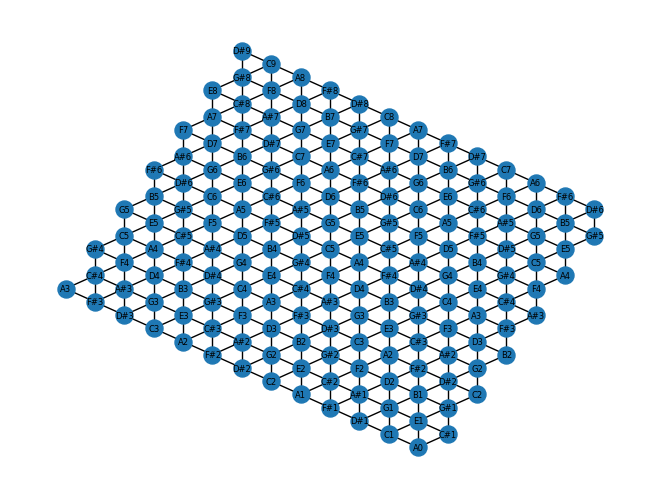

In [7]:
import random

import matplotlib.pyplot as plt

import song
from tonnetz import Tonnetz
t = Tonnetz()
t.draw()

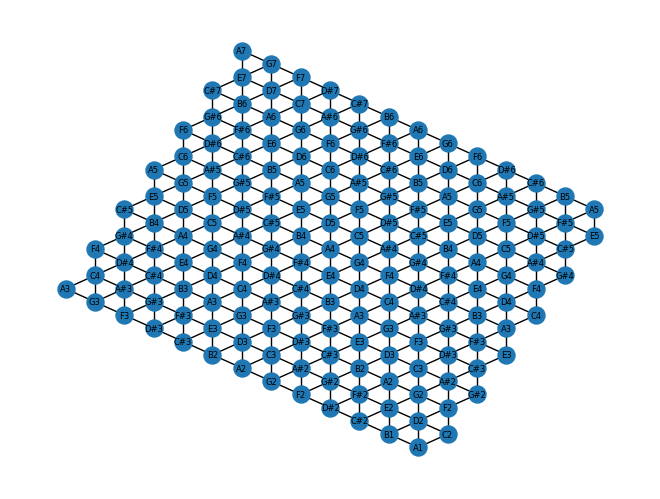

In [8]:
t = Tonnetz((2,3,7))
t.draw()

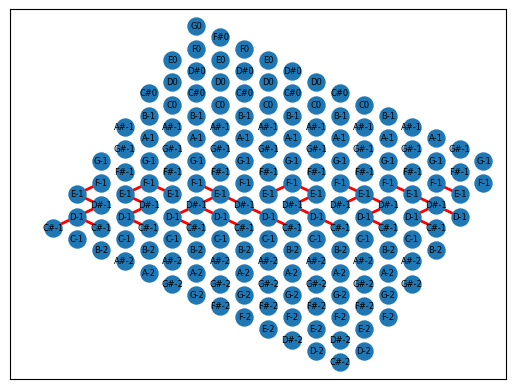

In [4]:
from tonnetz import TonnetzSong

ts = TonnetzSong((1,1,10), start_note=1)
ts.analyze([1, 2, 3, 4, 5])
ts.draw()


['C4', 'C4', 'G4', 'G4', 'A4', 'A4', 'G4', 'F4', 'F4', 'E4', 'E4', 'D4', 'D4', 'C4']


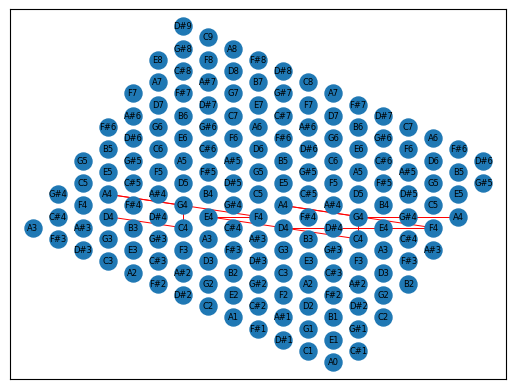

In [5]:
from song import SimpleSong
import matplotlib

s = SimpleSong("csvs/test.csv")
print(s)

ts2 = TonnetzSong()

ts2.analyze(s.notes)
ts2.draw()

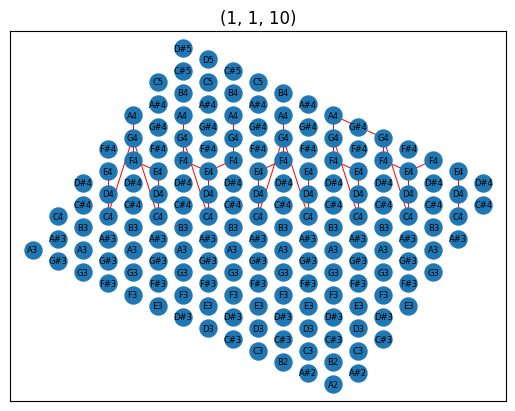

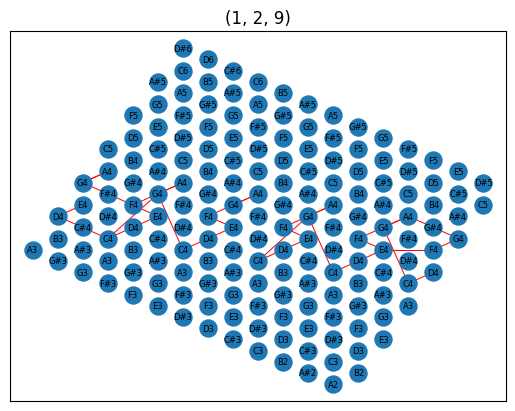

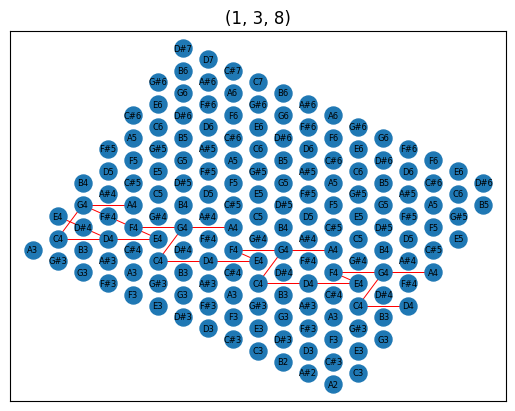

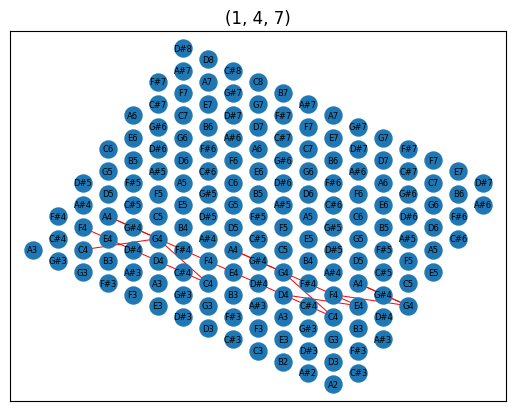

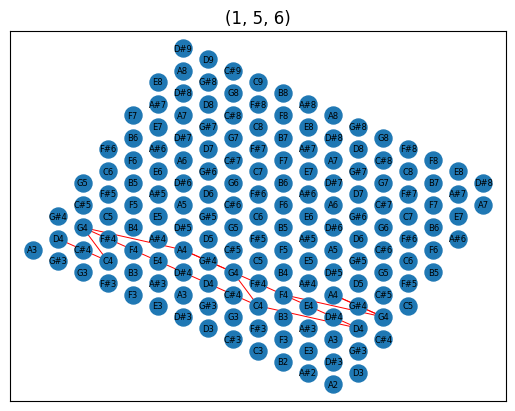

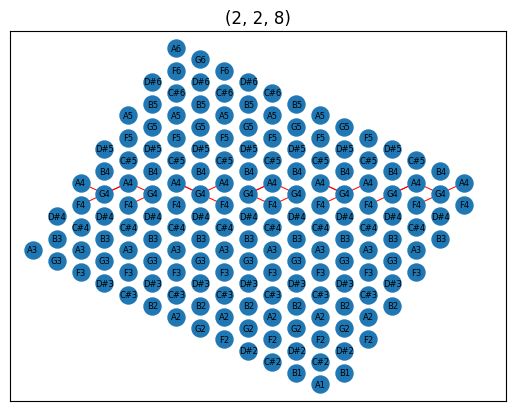

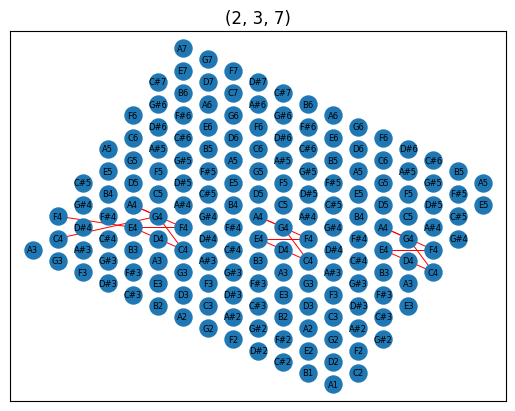

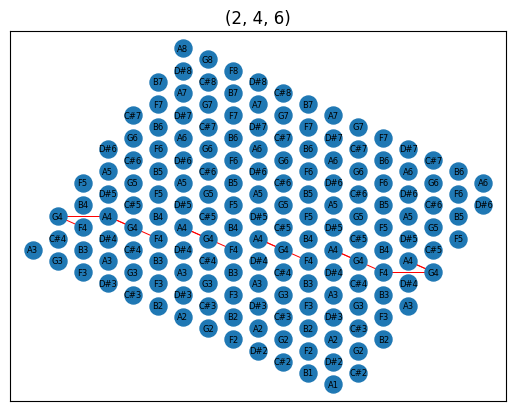

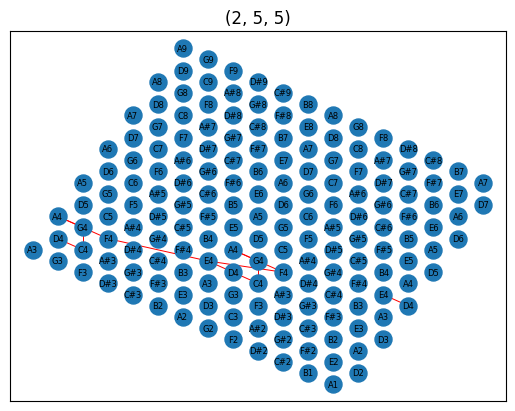

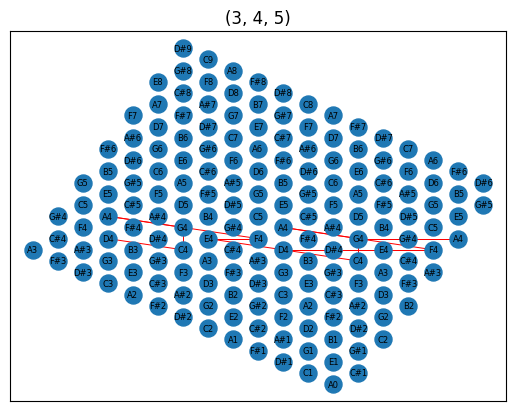

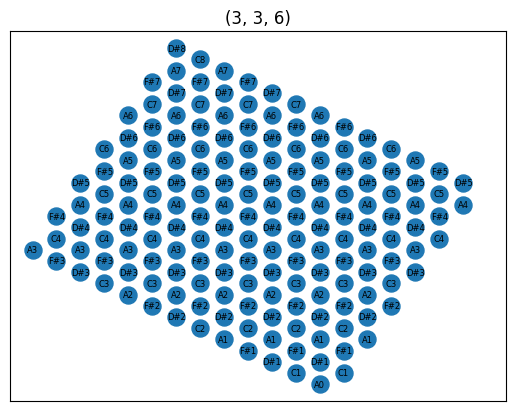

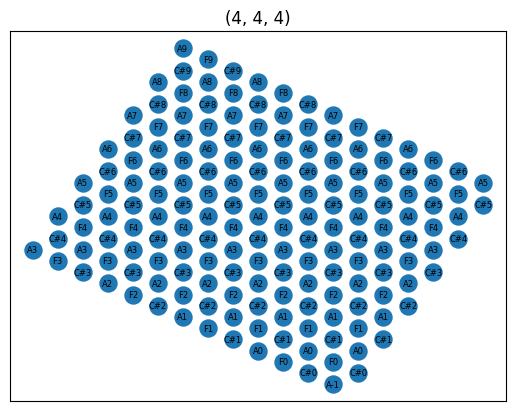

<Figure size 640x480 with 0 Axes>

In [6]:
from tonnetz import TONNETZ_INTERVALS

for interval in TONNETZ_INTERVALS:
    ts = TonnetzSong(intervals=interval)
    ts.analyze(s.notes)
    matplotlib.pyplot.title(f"{interval}")
    ts.draw()
    
    matplotlib.pyplot.figure()

## Note Transitions from MIDI file
Getting Note transitions when multiple notes are being played at once?

In [10]:
# Isolate Melody 

import mido

path = "data/clean_midi/ABBA/Dancing Queen.mid"
midi_file = mido.MidiFile(path, clip=True)

melody_track = None
for t in midi_file.tracks:
    if t.name == "Melody":
        melody_track = t
        
melody = mido.MidiFile()
melody.tracks.append(melody_track)

melody.save("data/test/DancingQueenMelody1.mid")


In [12]:
import os

ABBA_DIR = "data/clean_midi/ABBA/"
filteredPaths = []
# for path in sorted(os.listdir(ABBA_DIR)):
#     if any(char.isdigit() for char in path):
#         continue
#     try:
#         midi_file = mido.MidiFile(ABBA_DIR + path)
#         print(f"{path}, {midi_file.type}, {len(midi_file.tracks)}, {midi_file.length}")
#         if midi_file.type != 2:
#             # Ignore more complicated songs that have multiple independent tracks
#             filteredPaths.append(path)
#     except Exception as e:
#         print(f"{path}: {e}")
        
print(filteredPaths)

[]


In [13]:
import mido
dq = mido.MidiFile(ABBA_DIR + "Dancing Queen.mid")
# print(dq.tracks[3])

TRANSITION_COUNT_THRESH = 10 # Track must have at least 10 note transitions

def track_to_notes(track: mido.MidiTrack):
    notes = []
    last_note = None
    transitions = 0
    for msg in track:
        if msg.type == "note_on" and msg.velocity != 0:
            notes.append(msg.note)
            if msg.note != last_note:
                last_note = msg.note
                transitions += 1
            
    if transitions < TRANSITION_COUNT_THRESH: return []
    return notes


## Type 1 Song

Pretty good separation of elements in `type=1` song, which has separate tracks for each element

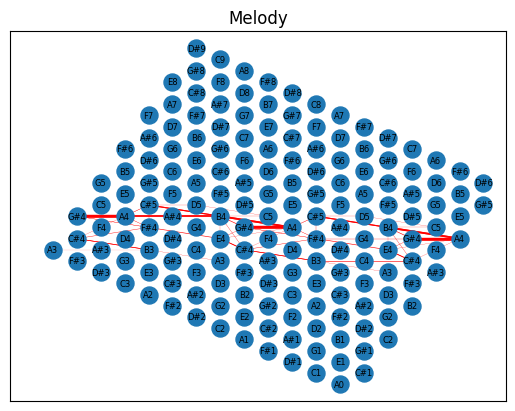

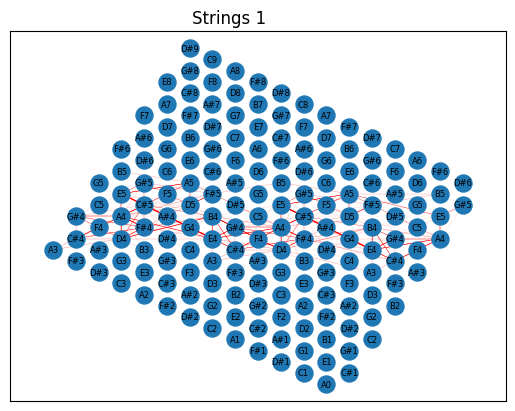

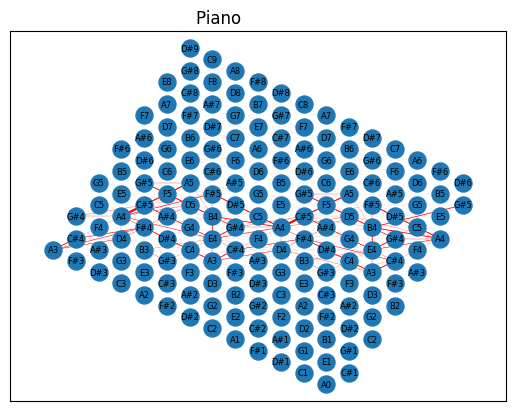

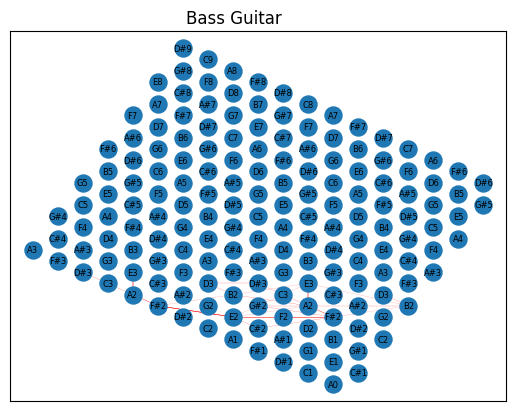

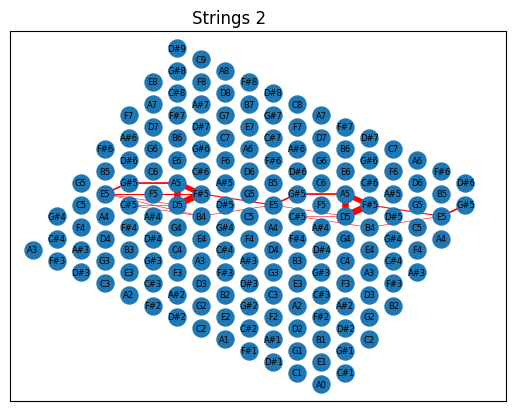

<Figure size 640x480 with 0 Axes>

In [14]:
from tonnetz import TonnetzSong
import matplotlib.pyplot as plt

for track in dq.tracks:
    ts = TonnetzSong()
    notes = track_to_notes(track)
    if len(notes) == 0:
        continue
    ts.analyze(notes)
    plt.title(f"{track.name}")
    ts.draw(edge_width_adjust=20)
    plt.figure()

## Type 0 Song
Doesn't seem feasible to analyze `type=0` song which only has 1 track with all of the instruments. Don't know of a good way to separate instruments

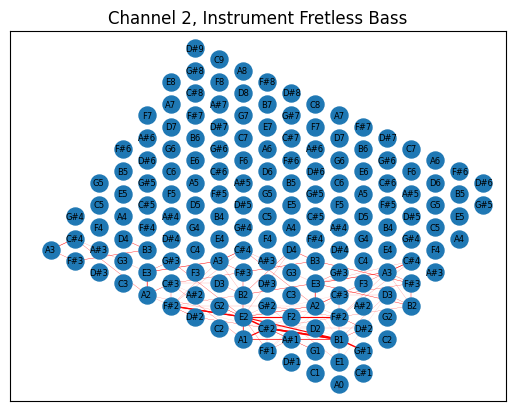

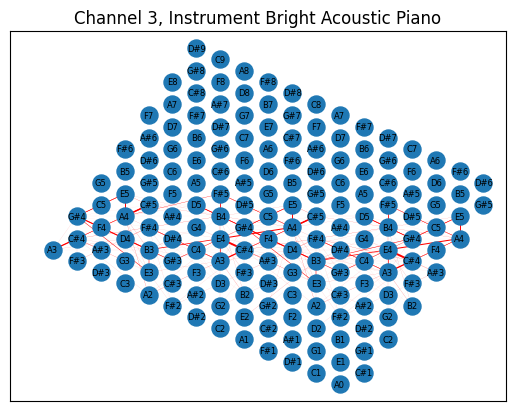

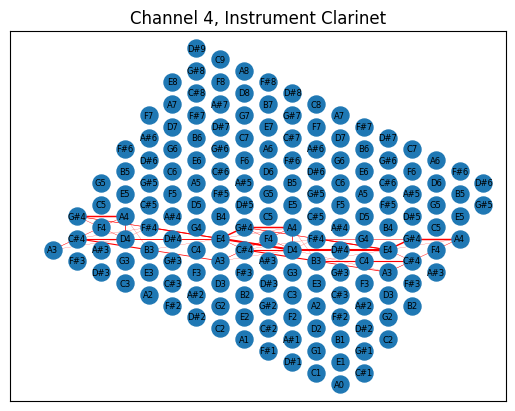

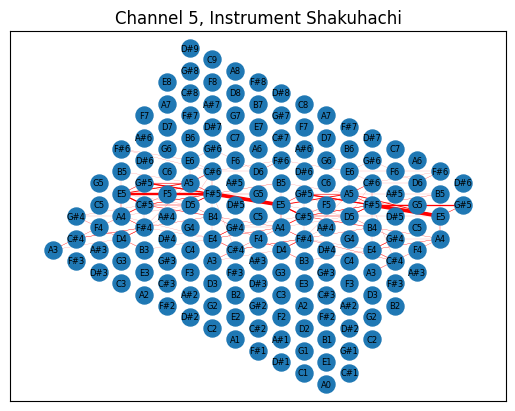

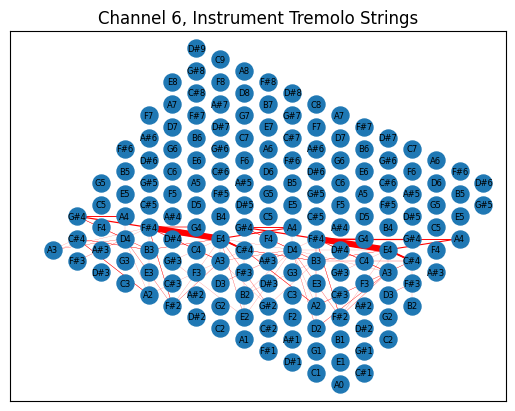

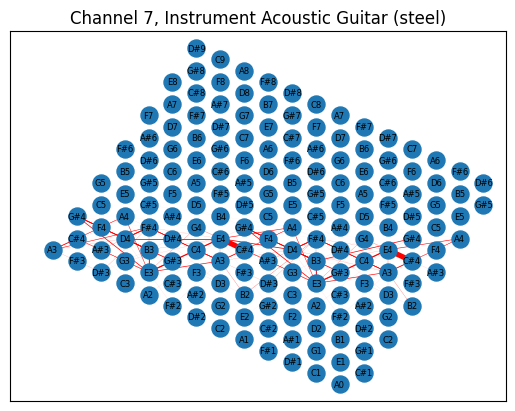

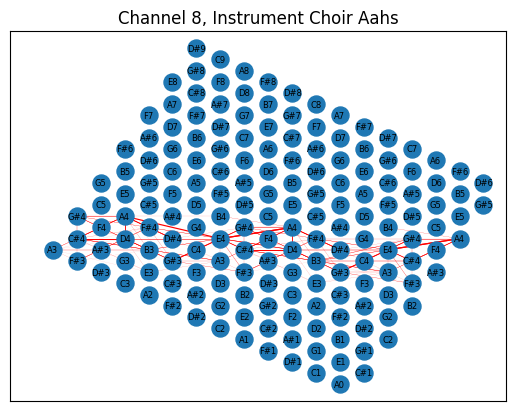

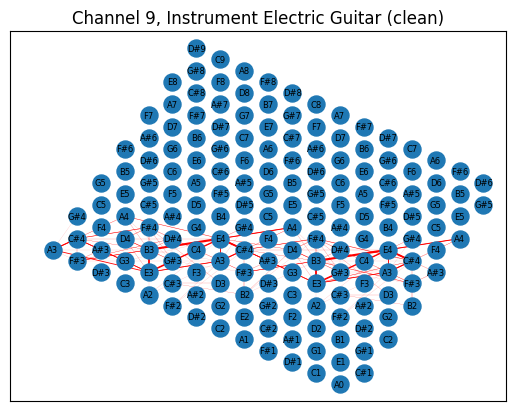

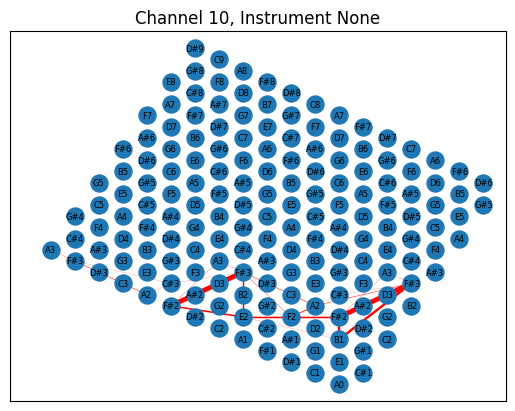

<Figure size 640x480 with 0 Axes>

In [15]:
from utils import GM_INSTRUMENT_NAMES

fer = mido.MidiFile(ABBA_DIR + "Fernando.mid")

MIDI_CHANNEL_COUNT = 16
def type_0_track_to_notes(track: mido.MidiTrack):
    channels = [[] for _ in range(MIDI_CHANNEL_COUNT)]  # Max 16 midi channels
    instruments = [None] * MIDI_CHANNEL_COUNT
    last_note = [None] * MIDI_CHANNEL_COUNT
    transitions = [0] * MIDI_CHANNEL_COUNT
    for msg in track:
        if msg.type == "program_change":
            instruments[msg.channel] = GM_INSTRUMENT_NAMES[msg.program]
        if msg.type == "note_on" and msg.velocity != 0:
            channels[msg.channel].append(msg.note)
            if msg.note != last_note[msg.channel - 1]:
                last_note[msg.channel - 1] = msg.note
                transitions[msg.channel - 1] += 1

    for i, tr in enumerate(transitions):
        if tr < TRANSITION_COUNT_THRESH:
            channels[i] = []
    return channels, instruments

channels, instruments = type_0_track_to_notes(fer.tracks[0])
channel_num = 0
for noteseq, instr in zip(channels, instruments):
    channel_num += 1
    ts = TonnetzSong()
    if len(noteseq) == 0:
        continue
    ts.analyze(noteseq)
    plt.title(f"Channel {channel_num}, Instrument {instr}")
    ts.draw(edge_width_adjust=20)
    plt.figure()


## Analyzing all Songs from an Artist
Instruments are separated and an image is generated showing relevant instruments and their note transitions across the Tonnetz graph

In [16]:
import mido
from tonnetz import TonnetzSong
from matplotlib import pyplot as plt
import utils

MAX_CHANNELS = 9

def graphs_from_song(path, output_root, show=True):

    midi_file = mido.MidiFile(path, clip=True)
    
    name = os.path.splitext(os.path.basename(path))[0] 
    artist = os.path.basename(os.path.dirname(path))
    output_path = os.path.join(output_root, name + ".png")
        
    channels, instruments = utils.mido_to_notes_and_instr(midi_file)

    xplots = 3
    yplots = 3
    fig, axes = plt.subplots(xplots, yplots, figsize=(20, 20))
    
    ts = TonnetzSong()
    idx = 0
    for channel, instr in zip(channels, instruments):
        if len(channel) == 0: continue
        if idx >= xplots * yplots: break
        
        ax = axes[idx // xplots, idx % yplots]
        ts.analyze(channel)
        ts.draw(edge_width_adjust=40, ax=ax)
        ax.set_title(f"{instr}")
        
        idx += 1

    for ax in axes.flatten():
        ax.set_axis_off()

    plt.subplots_adjust(wspace=0, hspace=0.1)
    fig.suptitle(f"{artist}, {name}", y=0.92)
    
    plt.savefig(output_path)
    if show:
        plt.show()
    plt.close(fig)
    
# graphs_from_song("data/clean_midi/ABBA/Dancing Queen.mid")

In [17]:
from tqdm import tqdm

def analyze_artist(data_root, artist, output_root):
    print("Analyzing {}".format(artist))
    
    song_dir = os.path.join(data_root, artist)
    output_dir = os.path.join(output_root, artist)
    os.makedirs(output_dir, exist_ok=True)
    
    for path in tqdm(sorted(os.listdir(song_dir))):
        if any(char.isdigit() for char in path):
            # Skip repeated versions of the song
            continue
        try:
            graphs_from_song(os.path.join(song_dir, path), output_dir, show=False)
        except Exception as e:
            print(f"{path}: {e}")
            

DATA_ROOT = "data/clean_midi"
OUTPUT_ROOT = "analysis/tonnetzImages"


In [18]:
analyze_artist(DATA_ROOT, "ABBA", OUTPUT_ROOT)


Analyzing ABBA


 39%|███▊      | 66/171 [00:15<00:31,  3.33it/s]

I've Been Waiting For You.mid: undefined status byte 0xf9


100%|██████████| 171/171 [00:39<00:00,  4.32it/s]


In [18]:
import random

artists = os.listdir(DATA_ROOT)
for i in range(5):
    art = random.choice(artists)

    analyze_artist(DATA_ROOT, art, OUTPUT_ROOT)


Analyzing Bach Johann Sebastian


  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [00:12<00:00,  6.34it/s]


Analyzing Swingin' Medallions


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Analyzing Warren Zevon


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Analyzing The Commitments


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Analyzing The Byrds


100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


In [ ]:
graphs_from_song("data/clean_midi/ABBA/Super Trooper.mid", "data/test", show=True)
graphs_from_song("data/clean_midi/ABBA/Super Trouper.mid", "data/test", show=True)


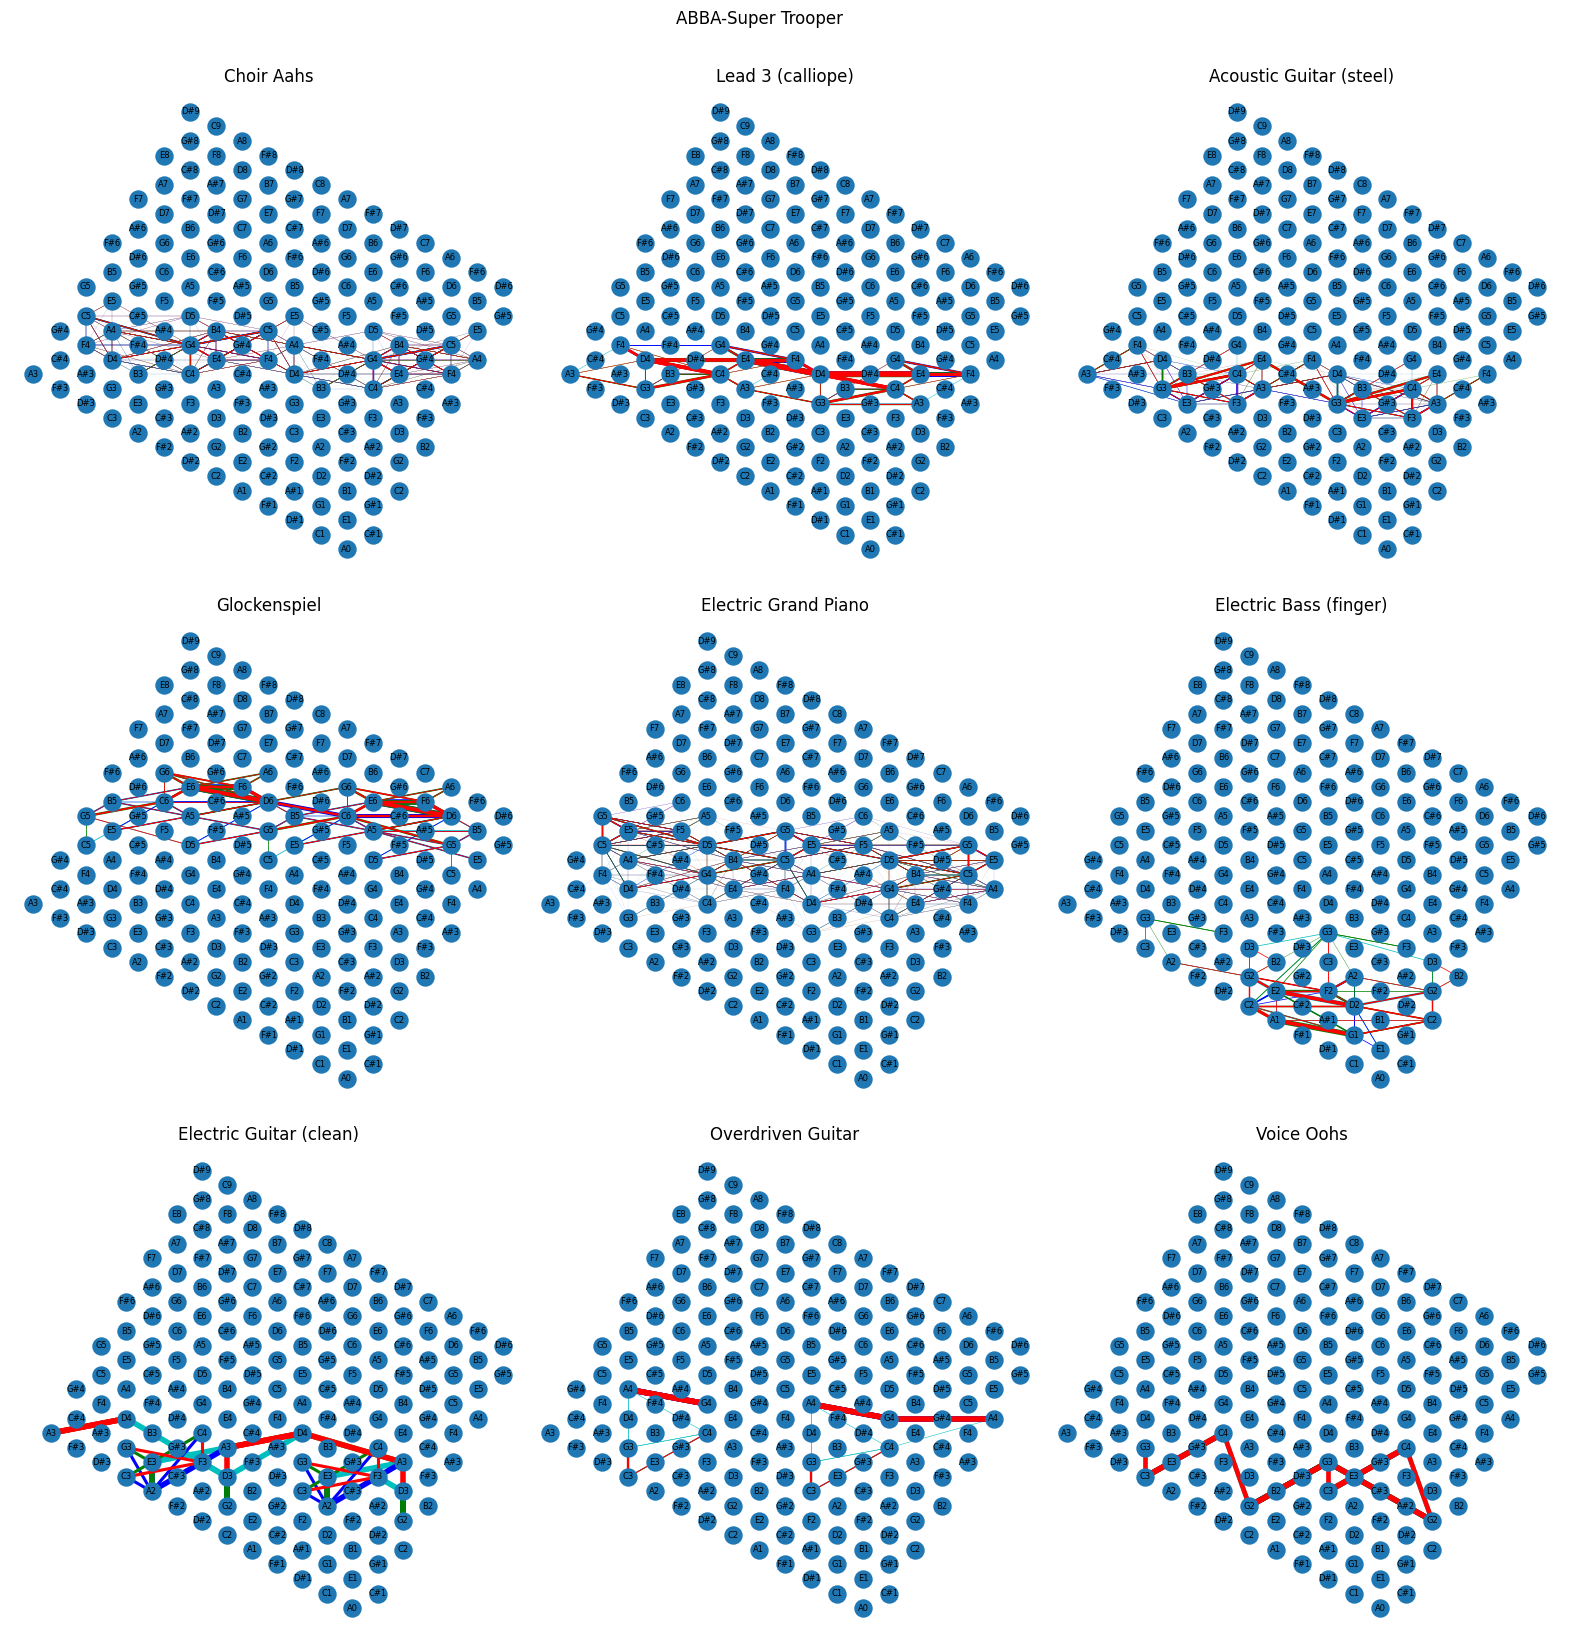

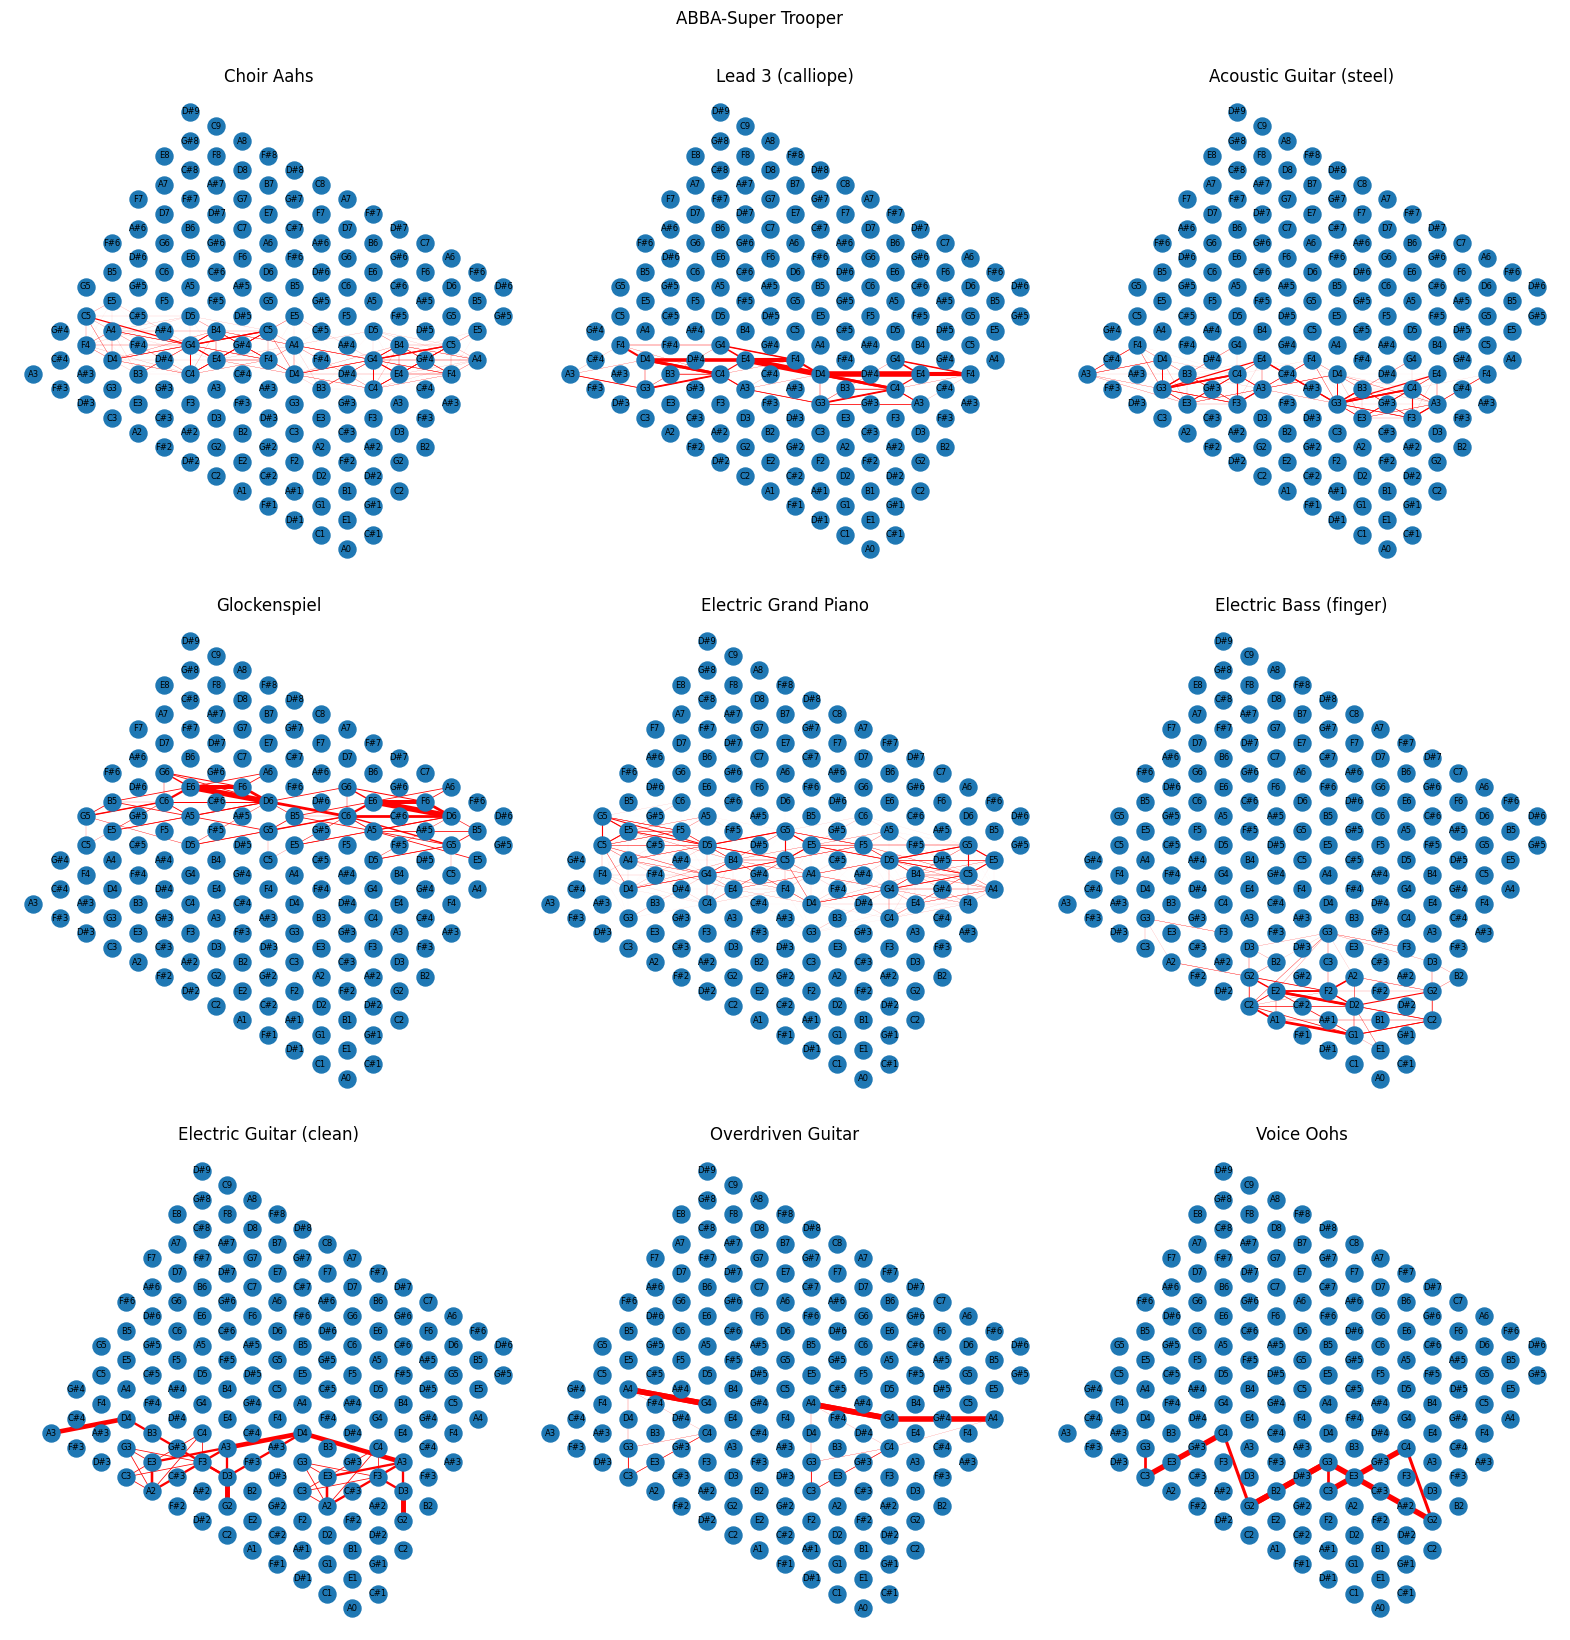

In [1]:
from song import AnalyzedSong

anS = AnalyzedSong("ABBA/Super Trooper.mid")
anS.draw(save_file=True, show_image=True)
anS.draw(save_file=True, show_image=True, draw_quarters=False)


False


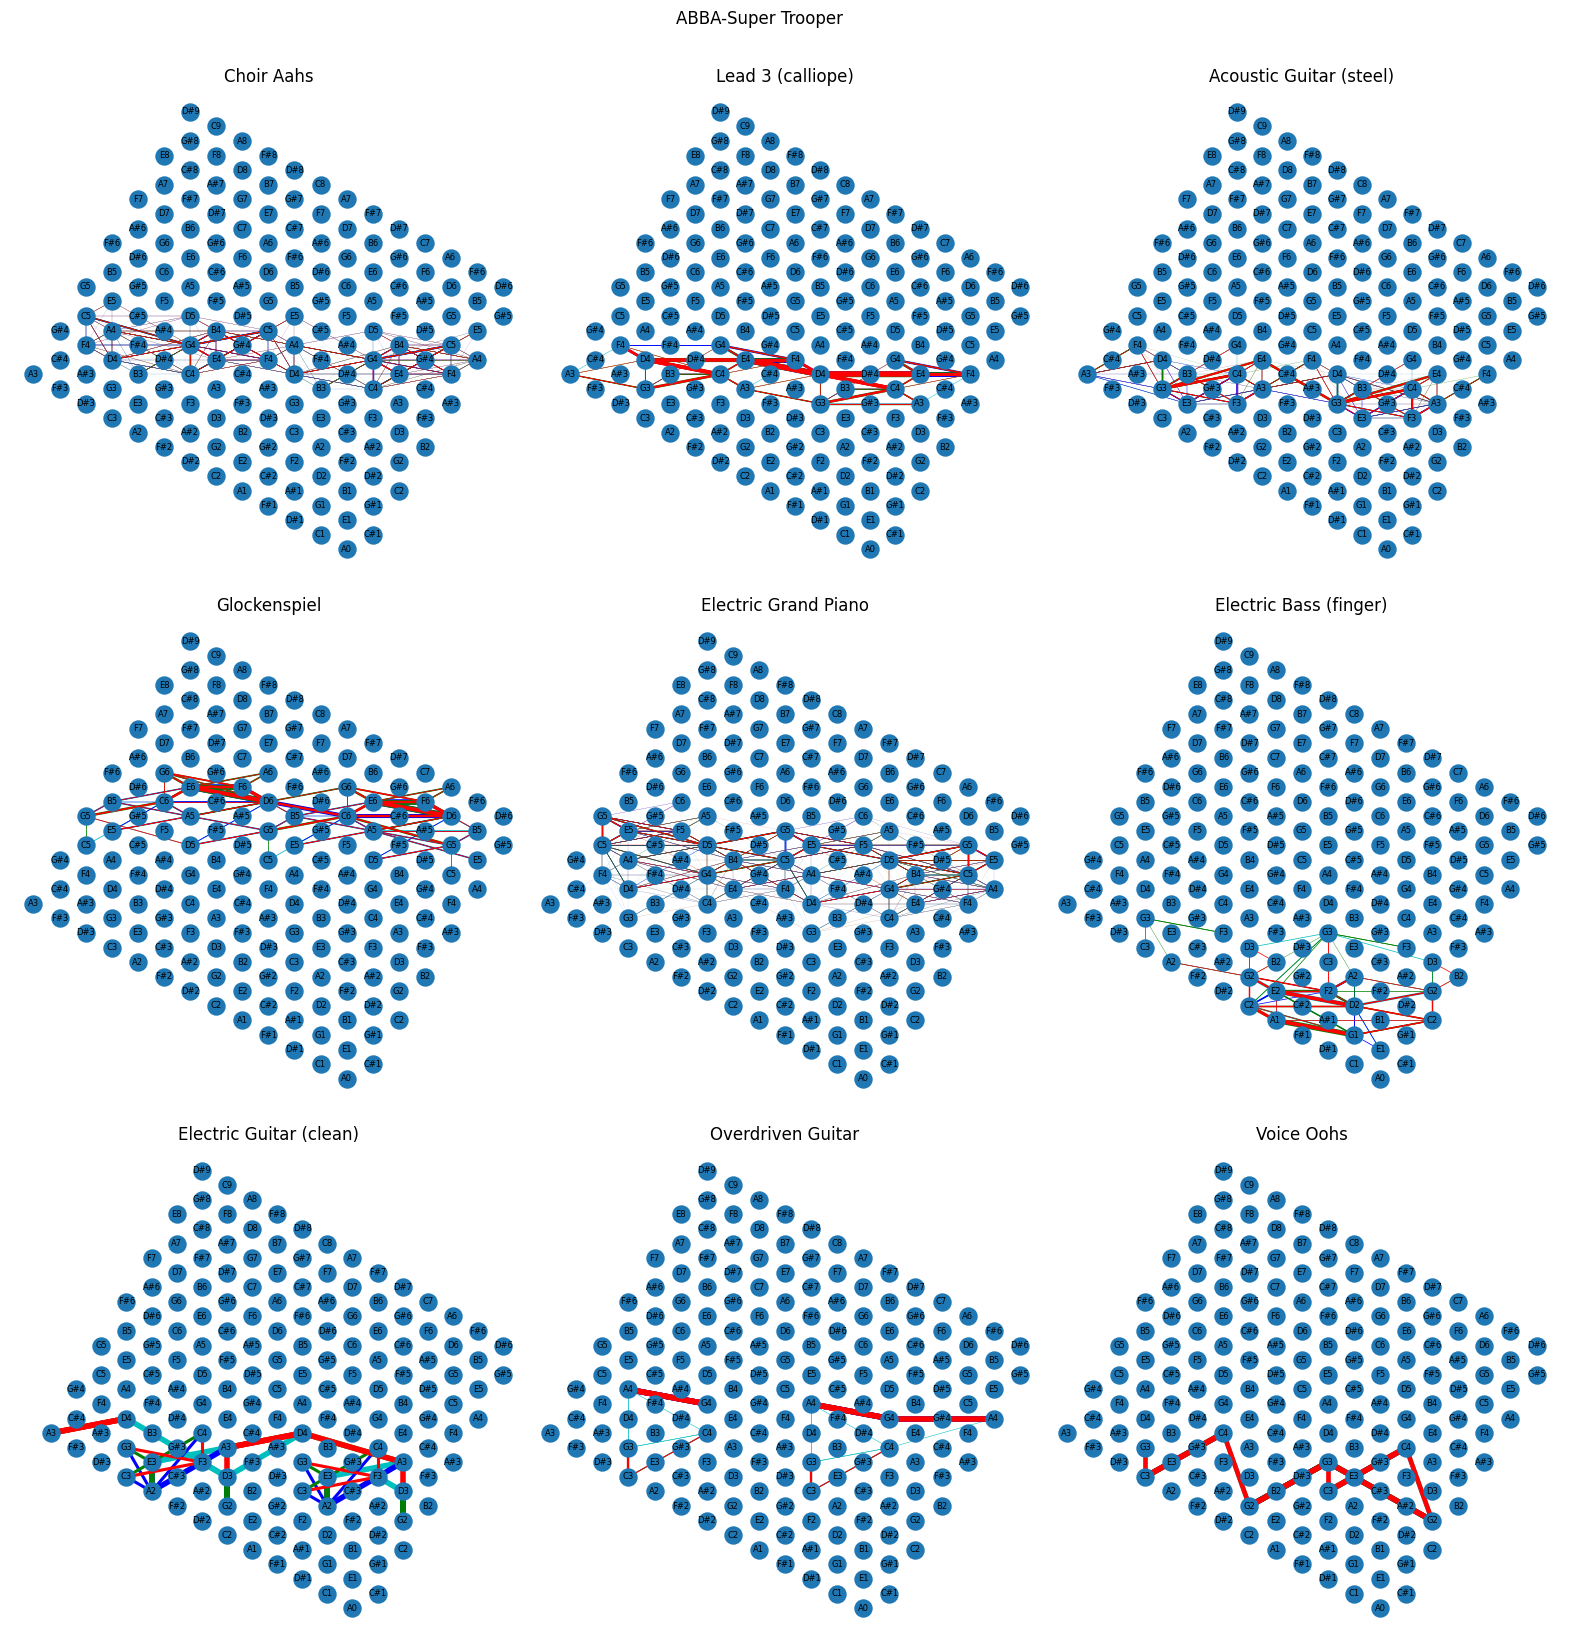

In [2]:
anS.save_pickle()

an2 = AnalyzedSong("ABBA-Super Trooper")

print(anS == an2)

an2.draw(save_file=False, show_image=True)

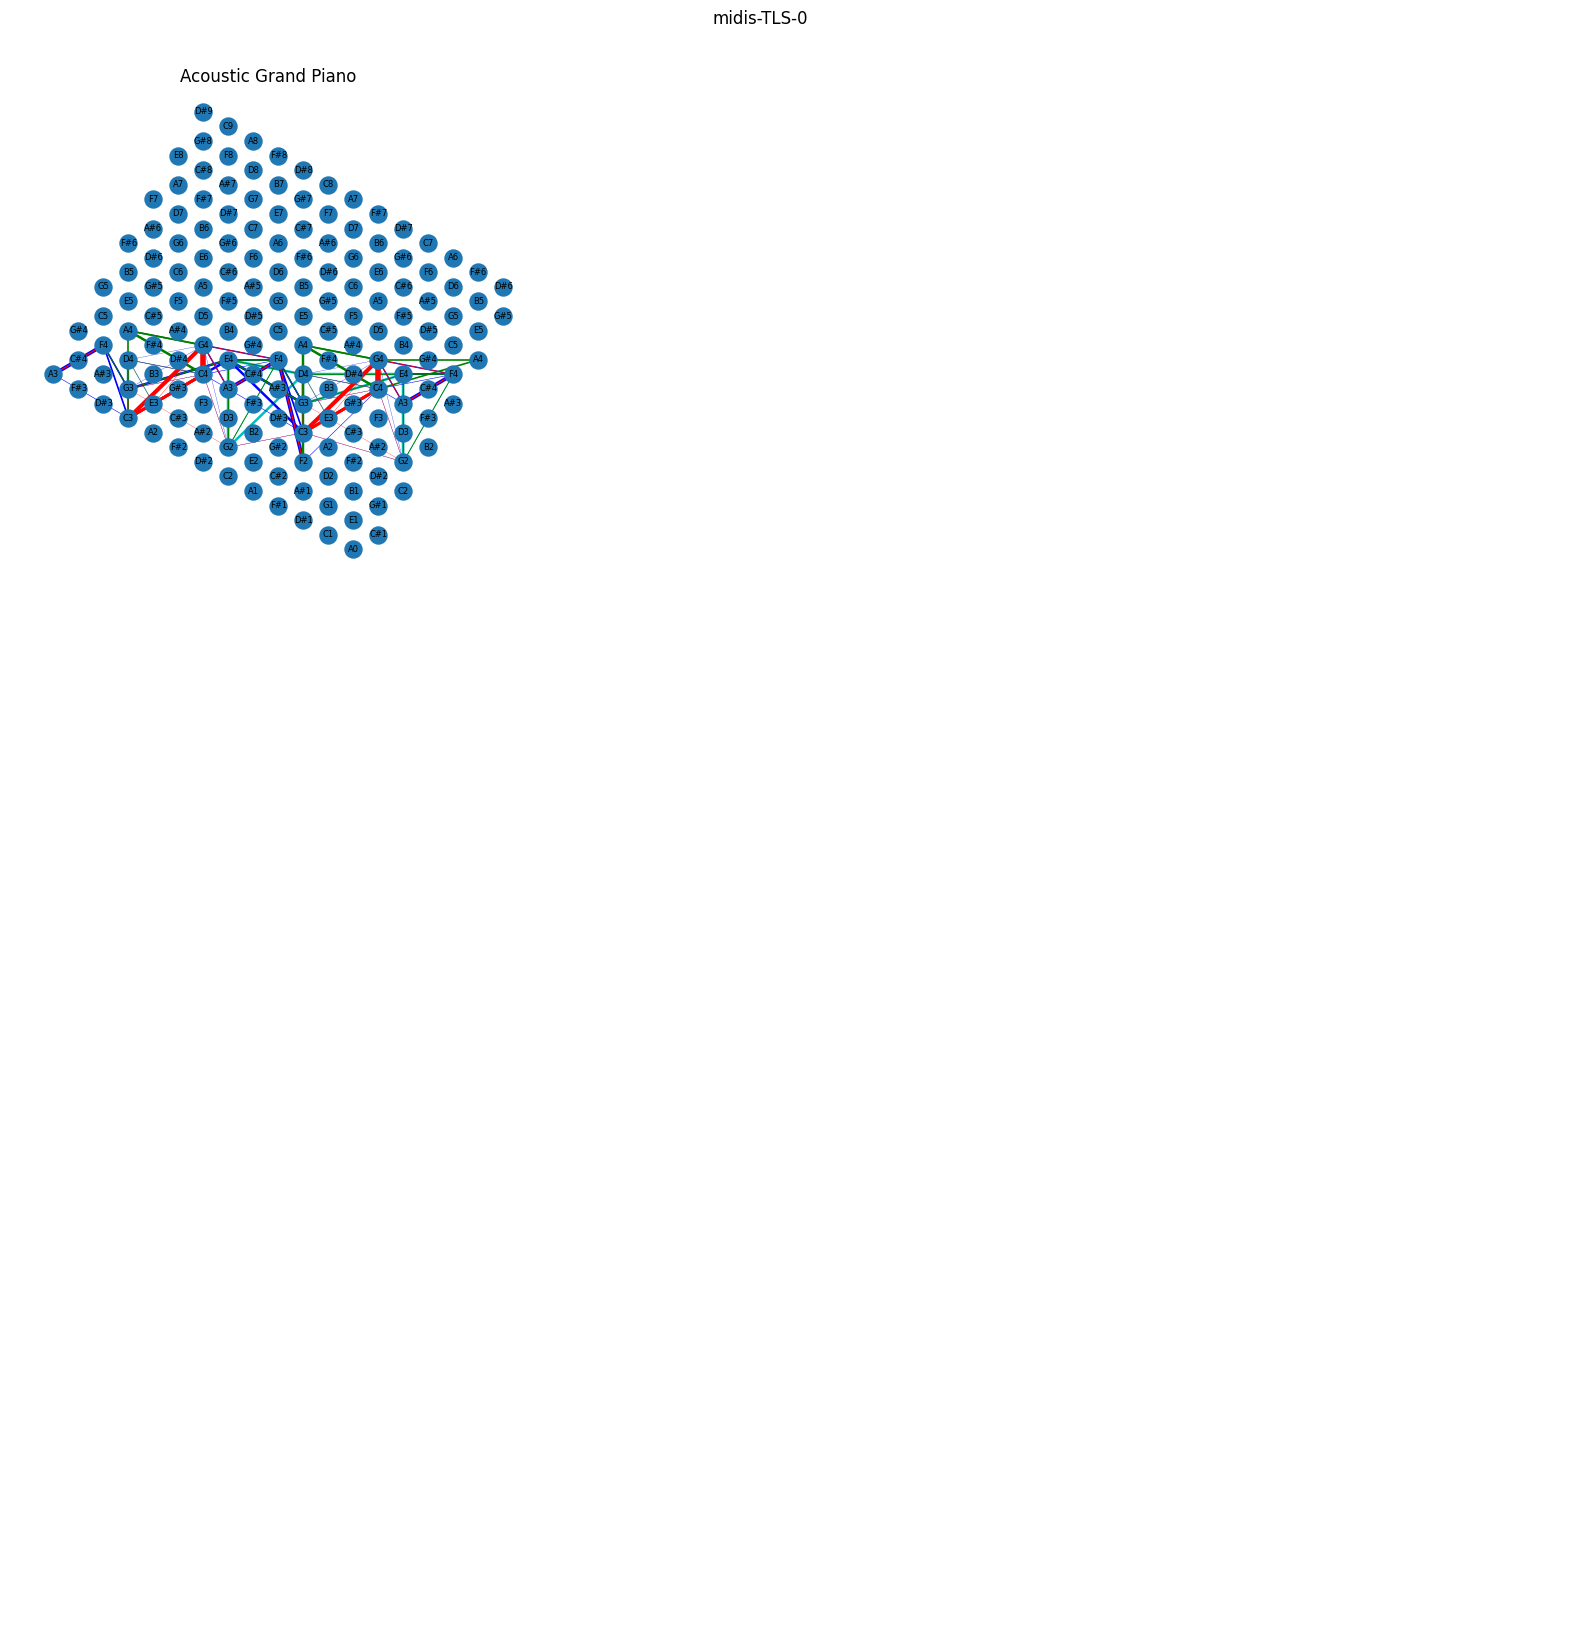

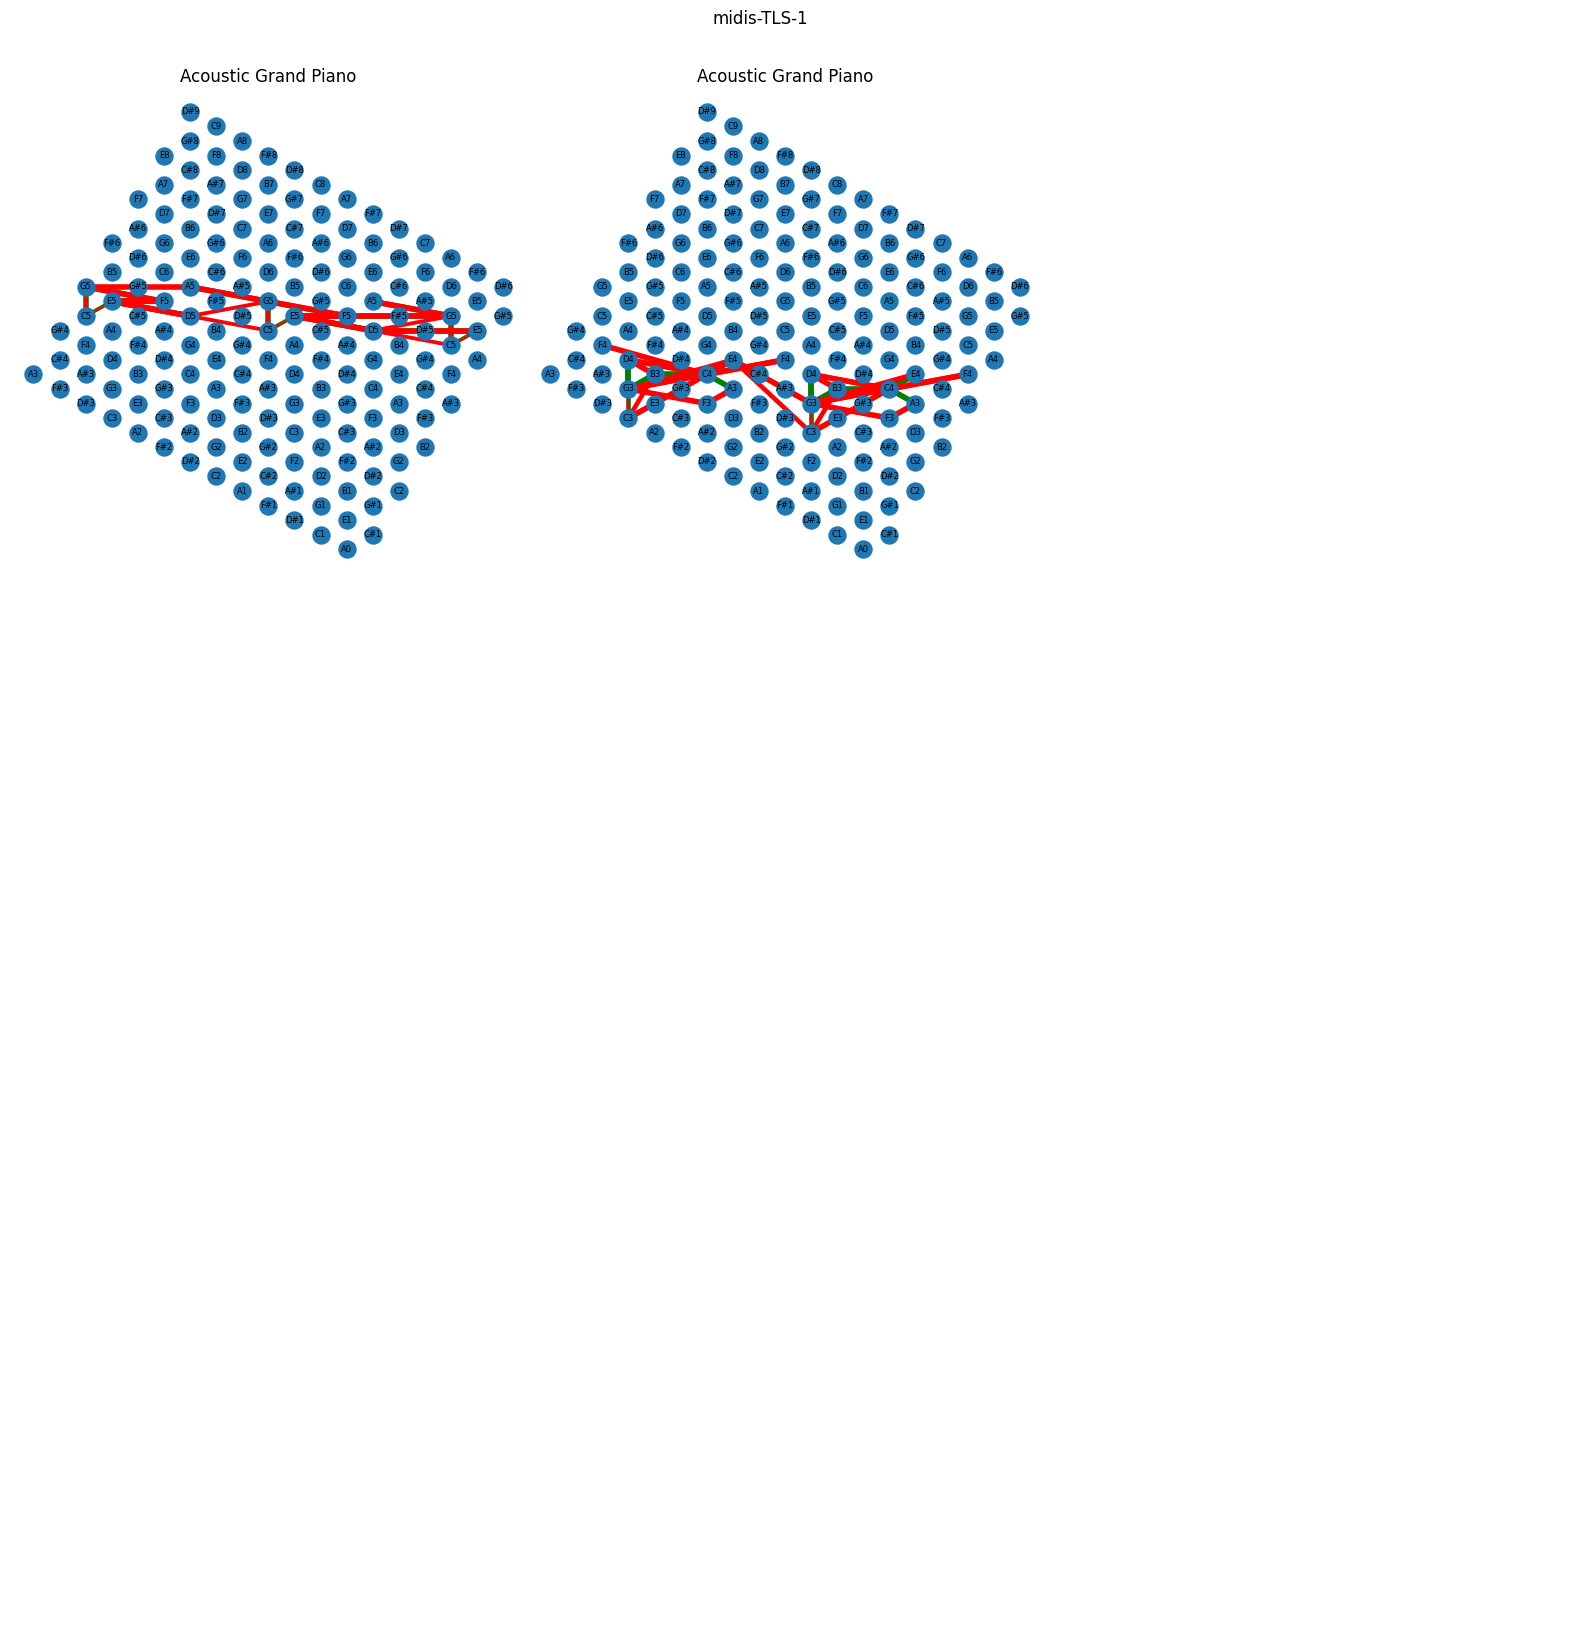

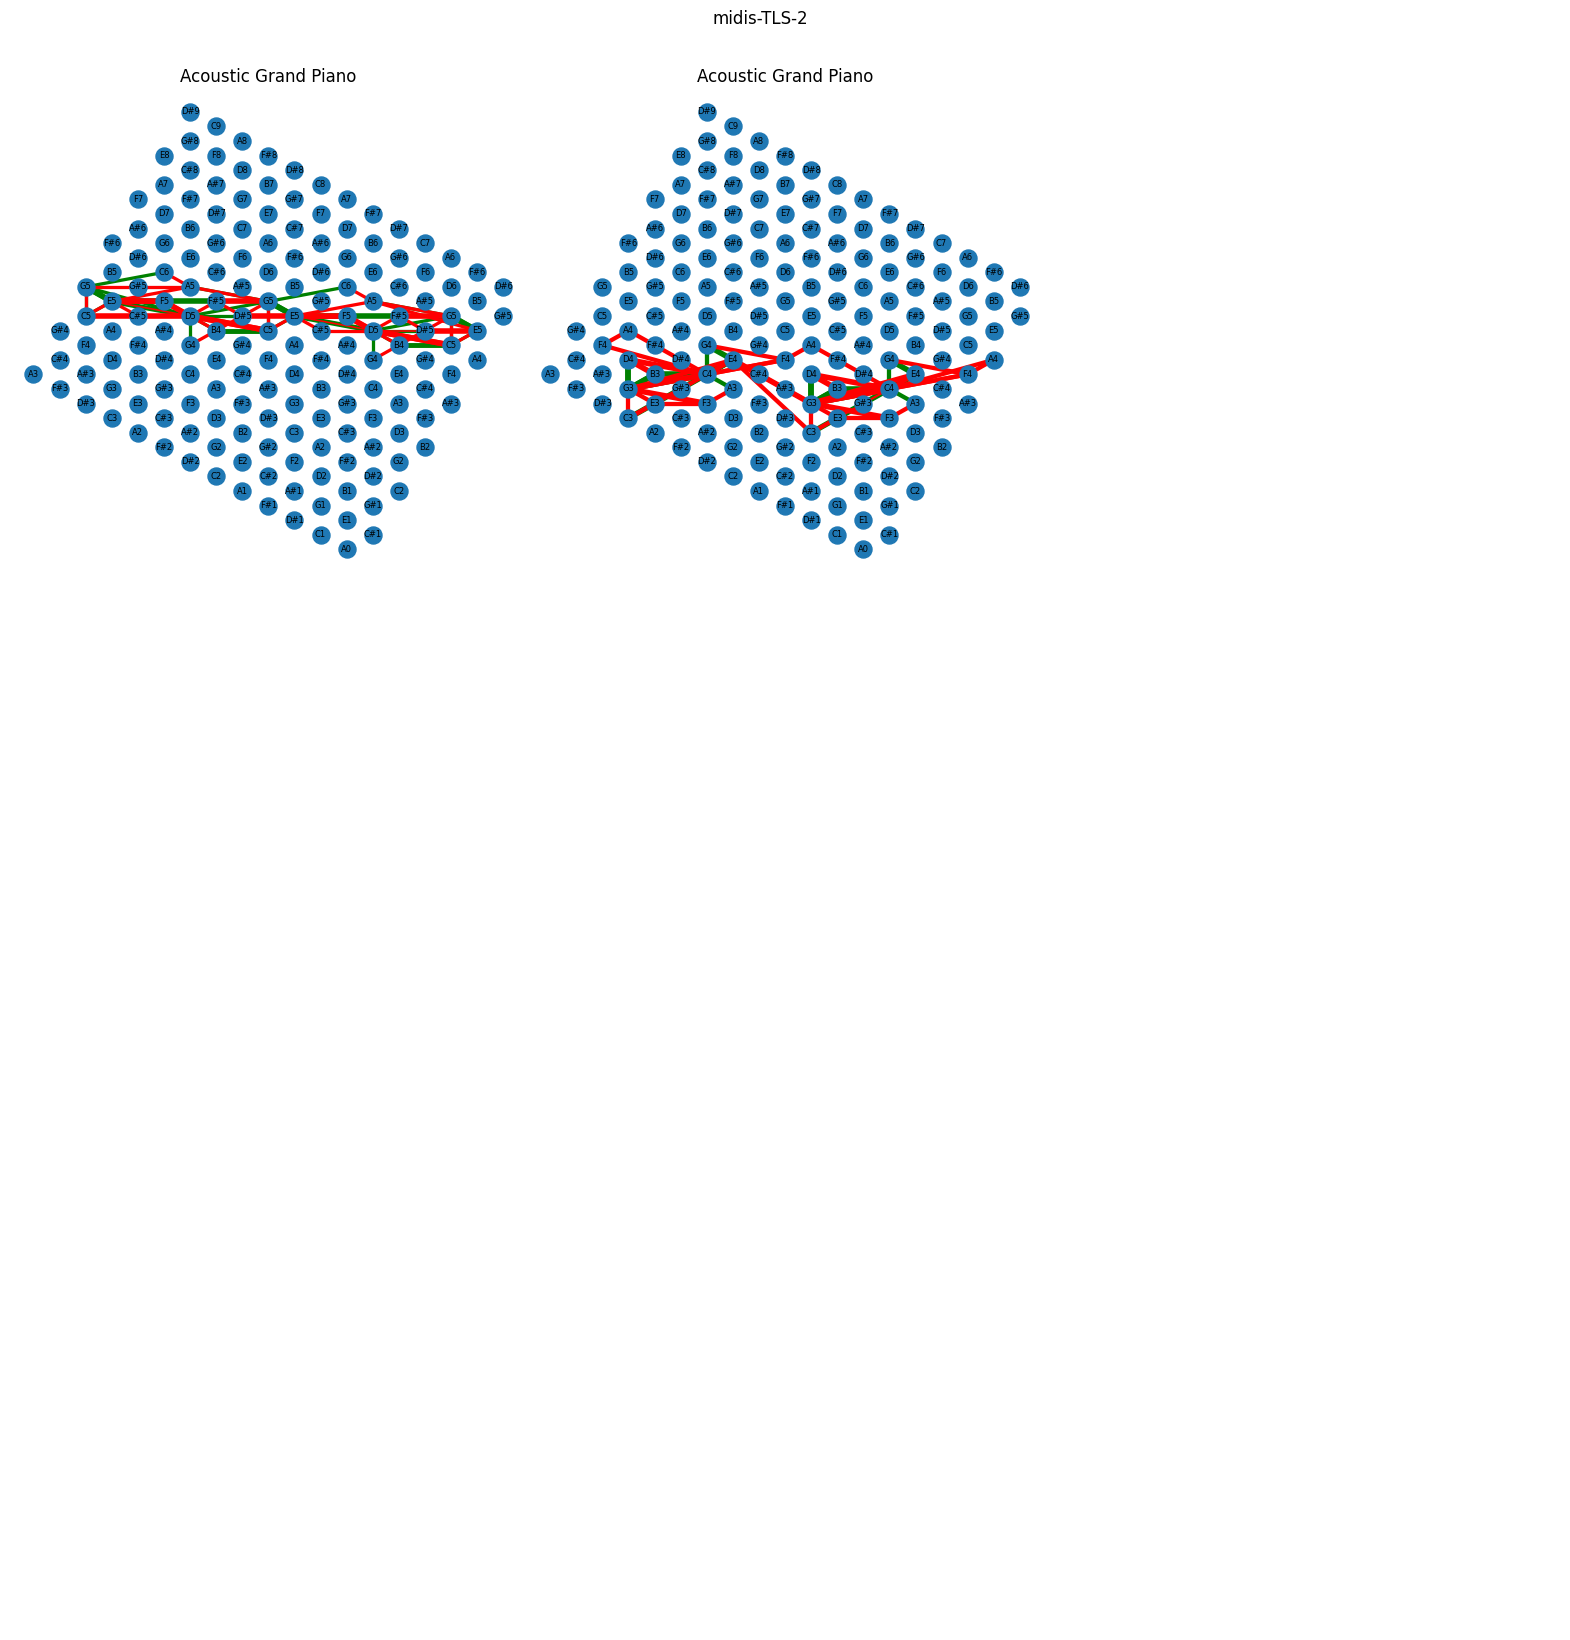

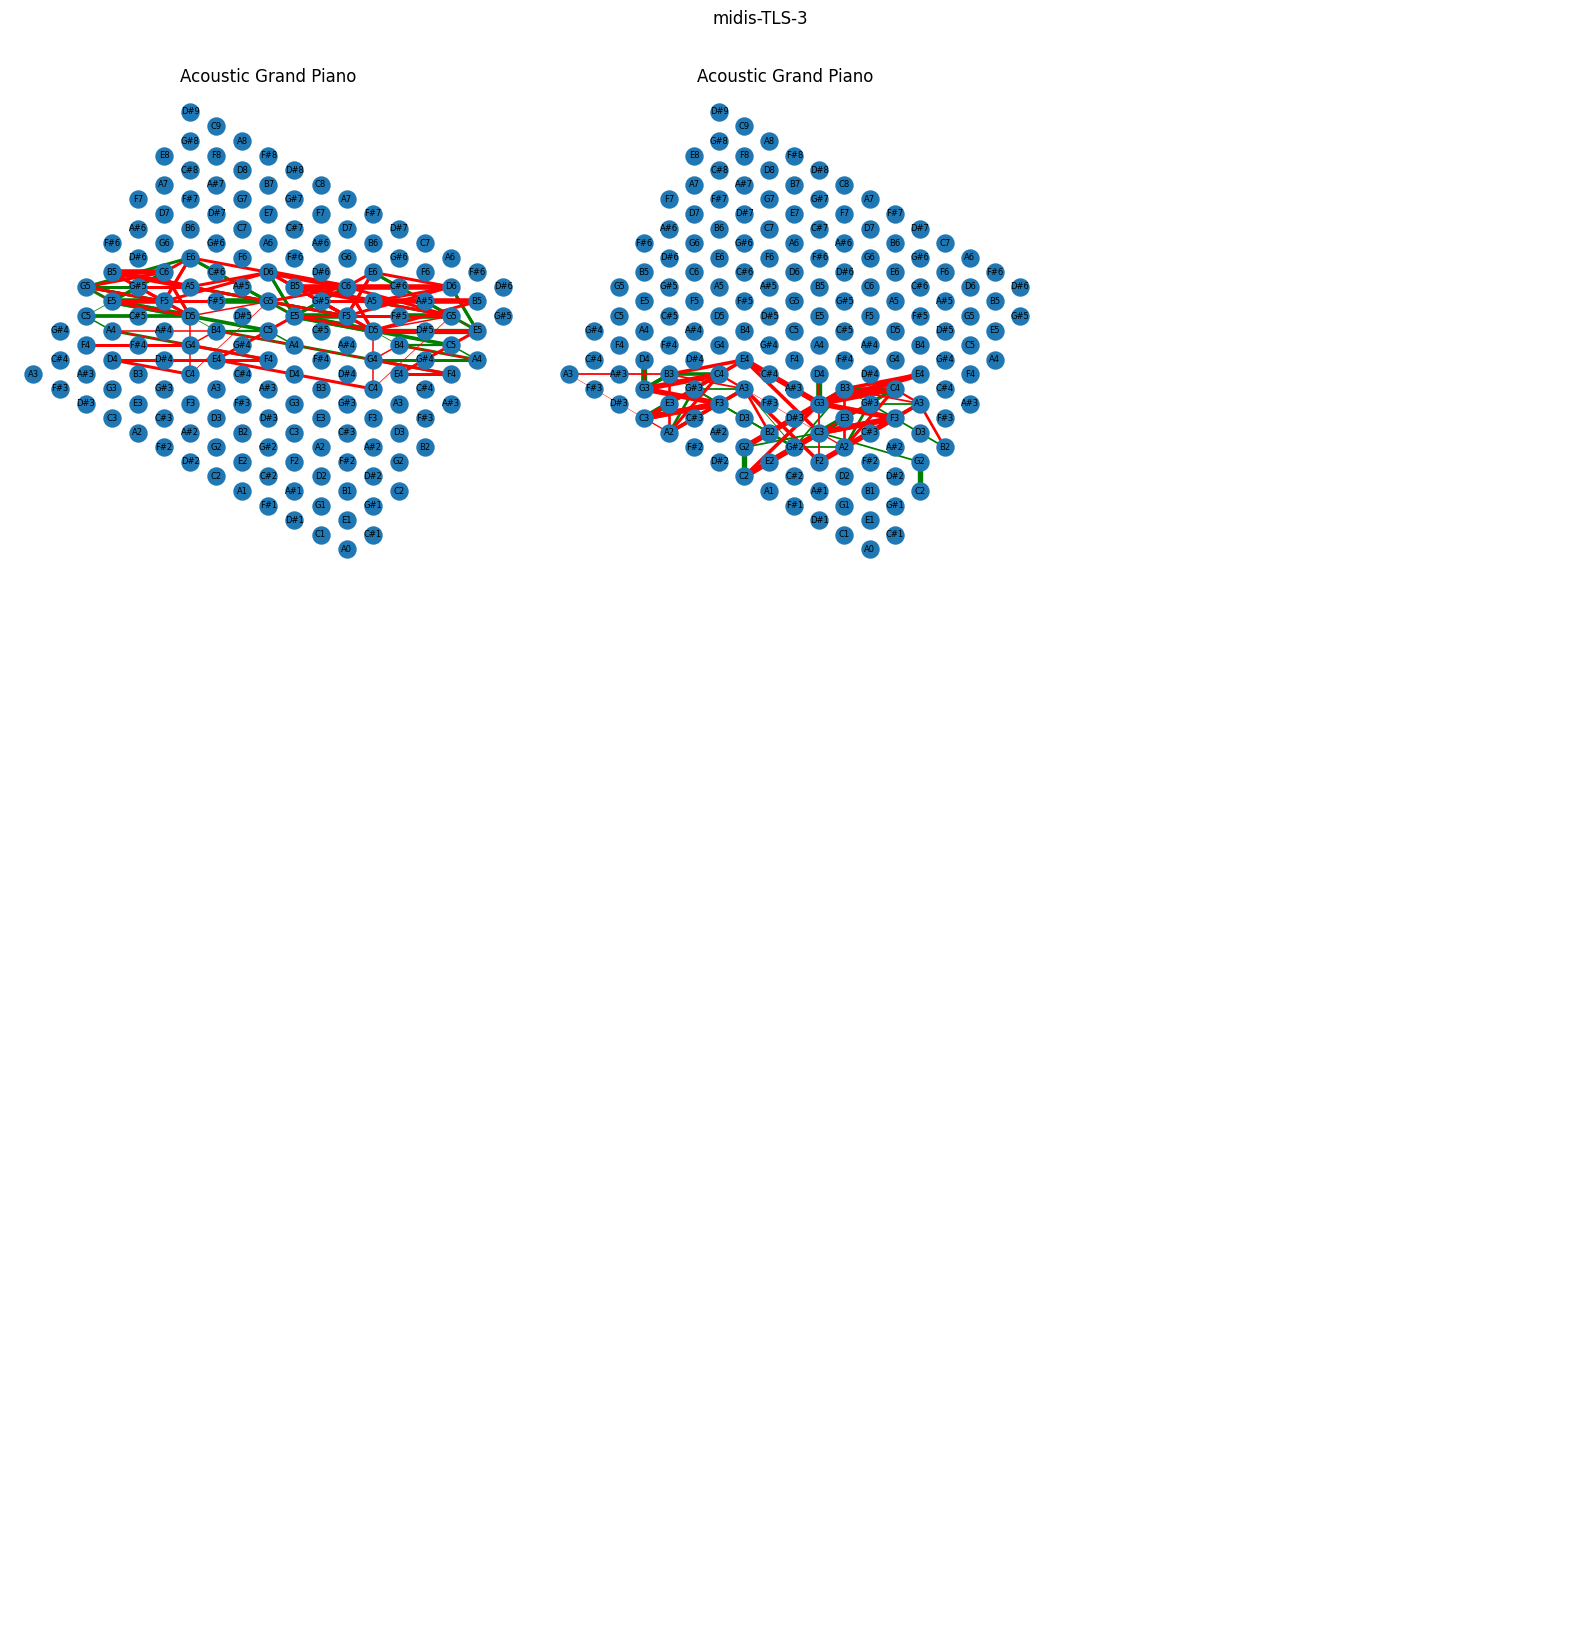

In [4]:
for i in range(4):
    tls = AnalyzedSong(f"midis/TLS-{i}.mid")
    tls.draw(save_file=True, show_image=True)

## Using AnalyzedSong

In [1]:
import os
from tqdm import tqdm
from song import AnalyzedSong
import utils

def analyze_artist(artist, skip_digits=True):
    print("Analyzing {}".format(artist))

    song_dir = os.path.join(utils.DATA_ROOT, artist)
    output_dir = os.path.join(utils.OUTPUT_ROOT, artist)
    os.makedirs(output_dir, exist_ok=True)

    for song_name in tqdm(sorted(os.listdir(song_dir))):
        if skip_digits and any(char.isdigit() for char in song_name):
            # Skip repeated versions of the song
            continue
        try:
            anSong = AnalyzedSong(os.path.join(artist, song_name))
            anSong.draw(save_file=True)
            anSong.save_pickle()
        except Exception as e:
            print(f"{song_name}: {e}")
            


In [6]:
analyze_artist("ABBA")

Analyzing ABBA


  0%|          | 0/171 [00:00<?, ?it/s]

 37%|███▋      | 63/171 [00:15<00:18,  5.71it/s]

I Have a Dream.mid: list index out of range


 39%|███▊      | 66/171 [00:16<00:27,  3.78it/s]

I've Been Waiting For You.mid: data byte must be in range 0..127


 66%|██████▌   | 113/171 [00:29<00:19,  3.02it/s]

One Of Us.mid: data byte must be in range 0..127


100%|██████████| 171/171 [00:44<00:00,  3.89it/s]


In [7]:
analyze_artist("AC DC")


Analyzing AC DC


  0%|          | 0/16 [00:00<?, ?it/s]

Back In Black.mid: list index out of range


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
 50%|█████     | 8/16 [00:03<00:03,  2.45it/s]

TNT.mid: list index out of range


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


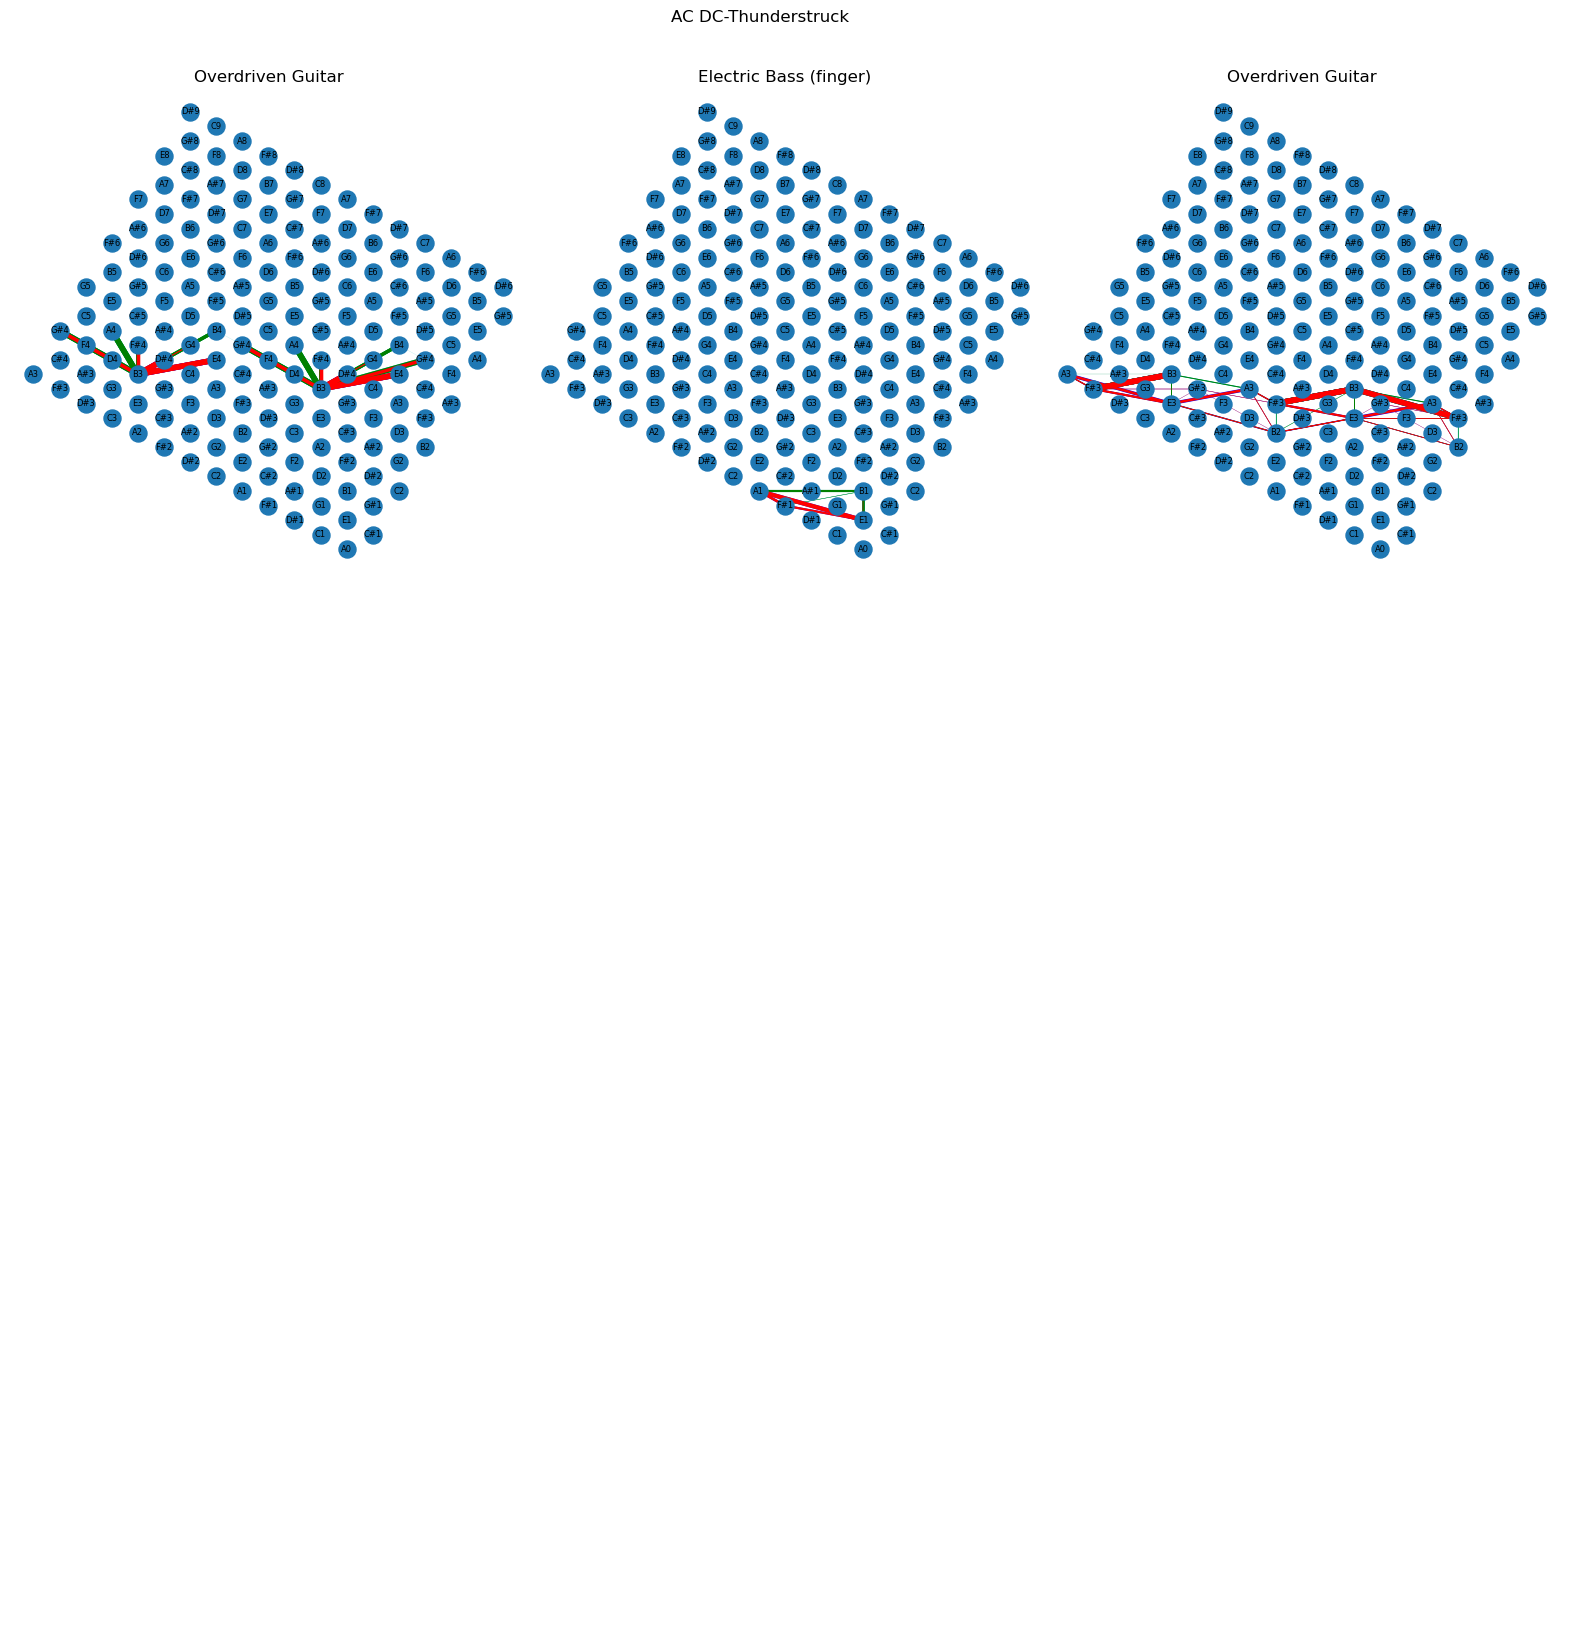

In [4]:
thunderstruck = AnalyzedSong("AC DC-Thunderstruck")
thunderstruck.draw(save_file=False, show_image=True)

## Song Comparison

In [9]:
from song import AnalyzedSong
from tonnetz import TonnetzQuarterTrack, NoteTransitions
import utils
import os

def edge_list_tonnetz_distance(e1: NoteTransitions, e2: NoteTransitions, offset=0):
    similarity = 0
    for transition in e1:
        other_transition = (transition[0] + offset, transition[1] + offset)
        if other_transition in e2:
            # We have a shared edge
            weight_diff = abs(e1[transition] - e2[other_transition])
            max_weight = max(e1[transition], e2[transition])
            # Further edges in Tonnetz are given more weight
            ton_dist = utils.tonnetz_dist(transition[0], transition[1])
            
            similarity += ton_dist * (1-weight_diff) * max_weight
    return similarity 
    

In [10]:
def simple_compare(song1: AnalyzedSong, song2: AnalyzedSong, max_channels=3):
    total_similarity = 0
    for c1, tr1 in enumerate(song1.tracks):
        if c1 == max_channels: break
        for c2, tr2 in enumerate(song2.tracks):
            if c2 == max_channels: break
            
            if len(tr1.note_number_transitions) != len(tr2.note_number_transitions):
                return 0  # TODO: Handle different number of quarter notes 
            
            for q in range(len(tr1.note_number_transitions)):
                # q is qnote number
                eltd = edge_list_tonnetz_distance(tr1.note_number_transitions[q], tr2.note_number_transitions[q])
                # print(f"{tr1.instrument}/{tr2.instrument} : Q{q} : {eltd}")
                total_similarity += eltd
            
    return total_similarity

In [3]:
# tls1 = AnalyzedSong("midis/TLS-1.mid")
# tls2 = AnalyzedSong("midis/TLS-2.mid")
# tls1.draw(show_image=True, save_file=False)
# tls2.draw(show_image=True, save_file=False)
# 
# simple_compare(tls1, tls2)

simple_compare(
    AnalyzedSong("ABBA/Super Trooper.mid"),
    AnalyzedSong("ABBA/Super Trouper.mid")
)

5.773027980779112

In [7]:
import pprint
dq = AnalyzedSong("ABBA/Dancing Queen.1.mid")

similarities = []

def calc_similarity(artist, song_name):
    other = AnalyzedSong(os.path.join(artist, song_name))
    other.save_pickle()
    similarities.append(
        (other.name, simple_compare(dq, other))
    )

utils.for_song_in_artist("ABBA", calc_similarity, skip_digits=False, report_errors=False)
pprint.pprint(sorted(similarities, key=lambda x : x[1], reverse=True))  # Sorted by sim


100%|██████████| 171/171 [00:37<00:00,  4.60it/s]

[('Dancing Queen.10', 4.183712515706856),
 ('Dancing Queen.11', 4.183712515706856),
 ('Dancing Queen.12', 4.183712515706856),
 ('Dancing Queen.3', 4.183712515706856),
 ('Dancing Queen.1', 4.175258570638429),
 ('Dancing Queen.8', 4.016446779760937),
 ('Dancing Queen', 4.016446779760937),
 ('Dancing Queen.4', 3.905510523806848),
 ('Fernando.2', 3.592583603090628),
 ('Fernando.9', 3.474737909807099),
 ('Fernando', 3.474737909807099),
 ('Fernando.11', 3.469982181930424),
 ('Fernando.1', 3.4677269884803534),
 ('Fernando.7', 3.455321631665689),
 ('Thank You for the Music', 3.289144900530716),
 ('Thank You for the Music.3', 3.28572090539026),
 ('Thank You for the Music.4', 3.284437074877207),
 ('Fernando.8', 3.2810189681988193),
 ('Thank You for the Music.5', 3.2809645778546646),
 ('Fernando.4', 3.2524469675164247),
 ('Name of the Game.2', 3.1063168322239365),
 ('Thank You for the Music.8', 3.0191313563342854),
 ('Thank You for the Music.9', 3.0120936412089376),
 ('Knowing Me, Knowing You.4',

#### Similar Songs
(Note, only first 3 channels compared)

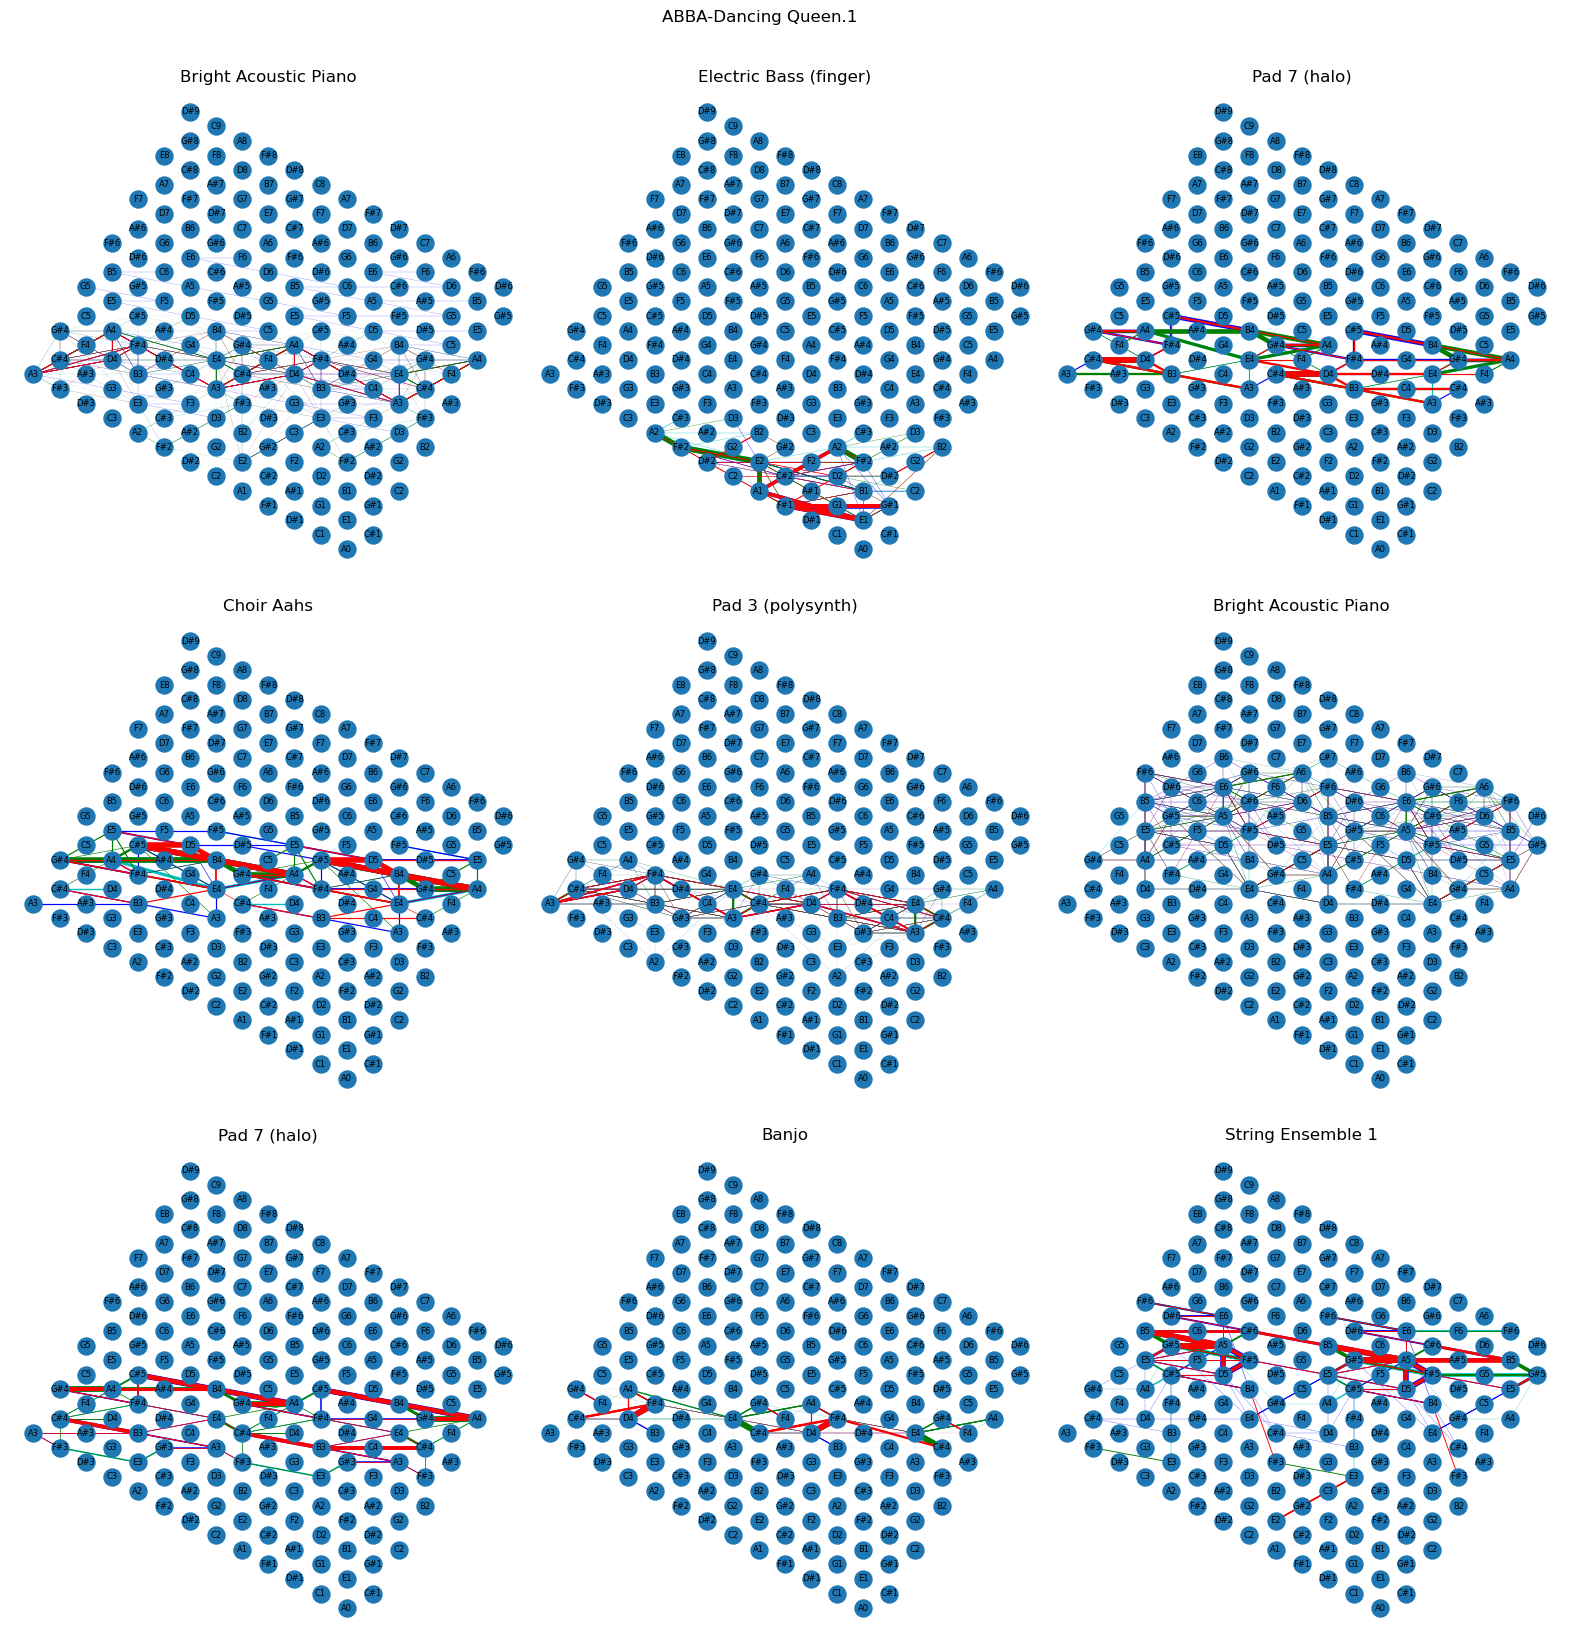

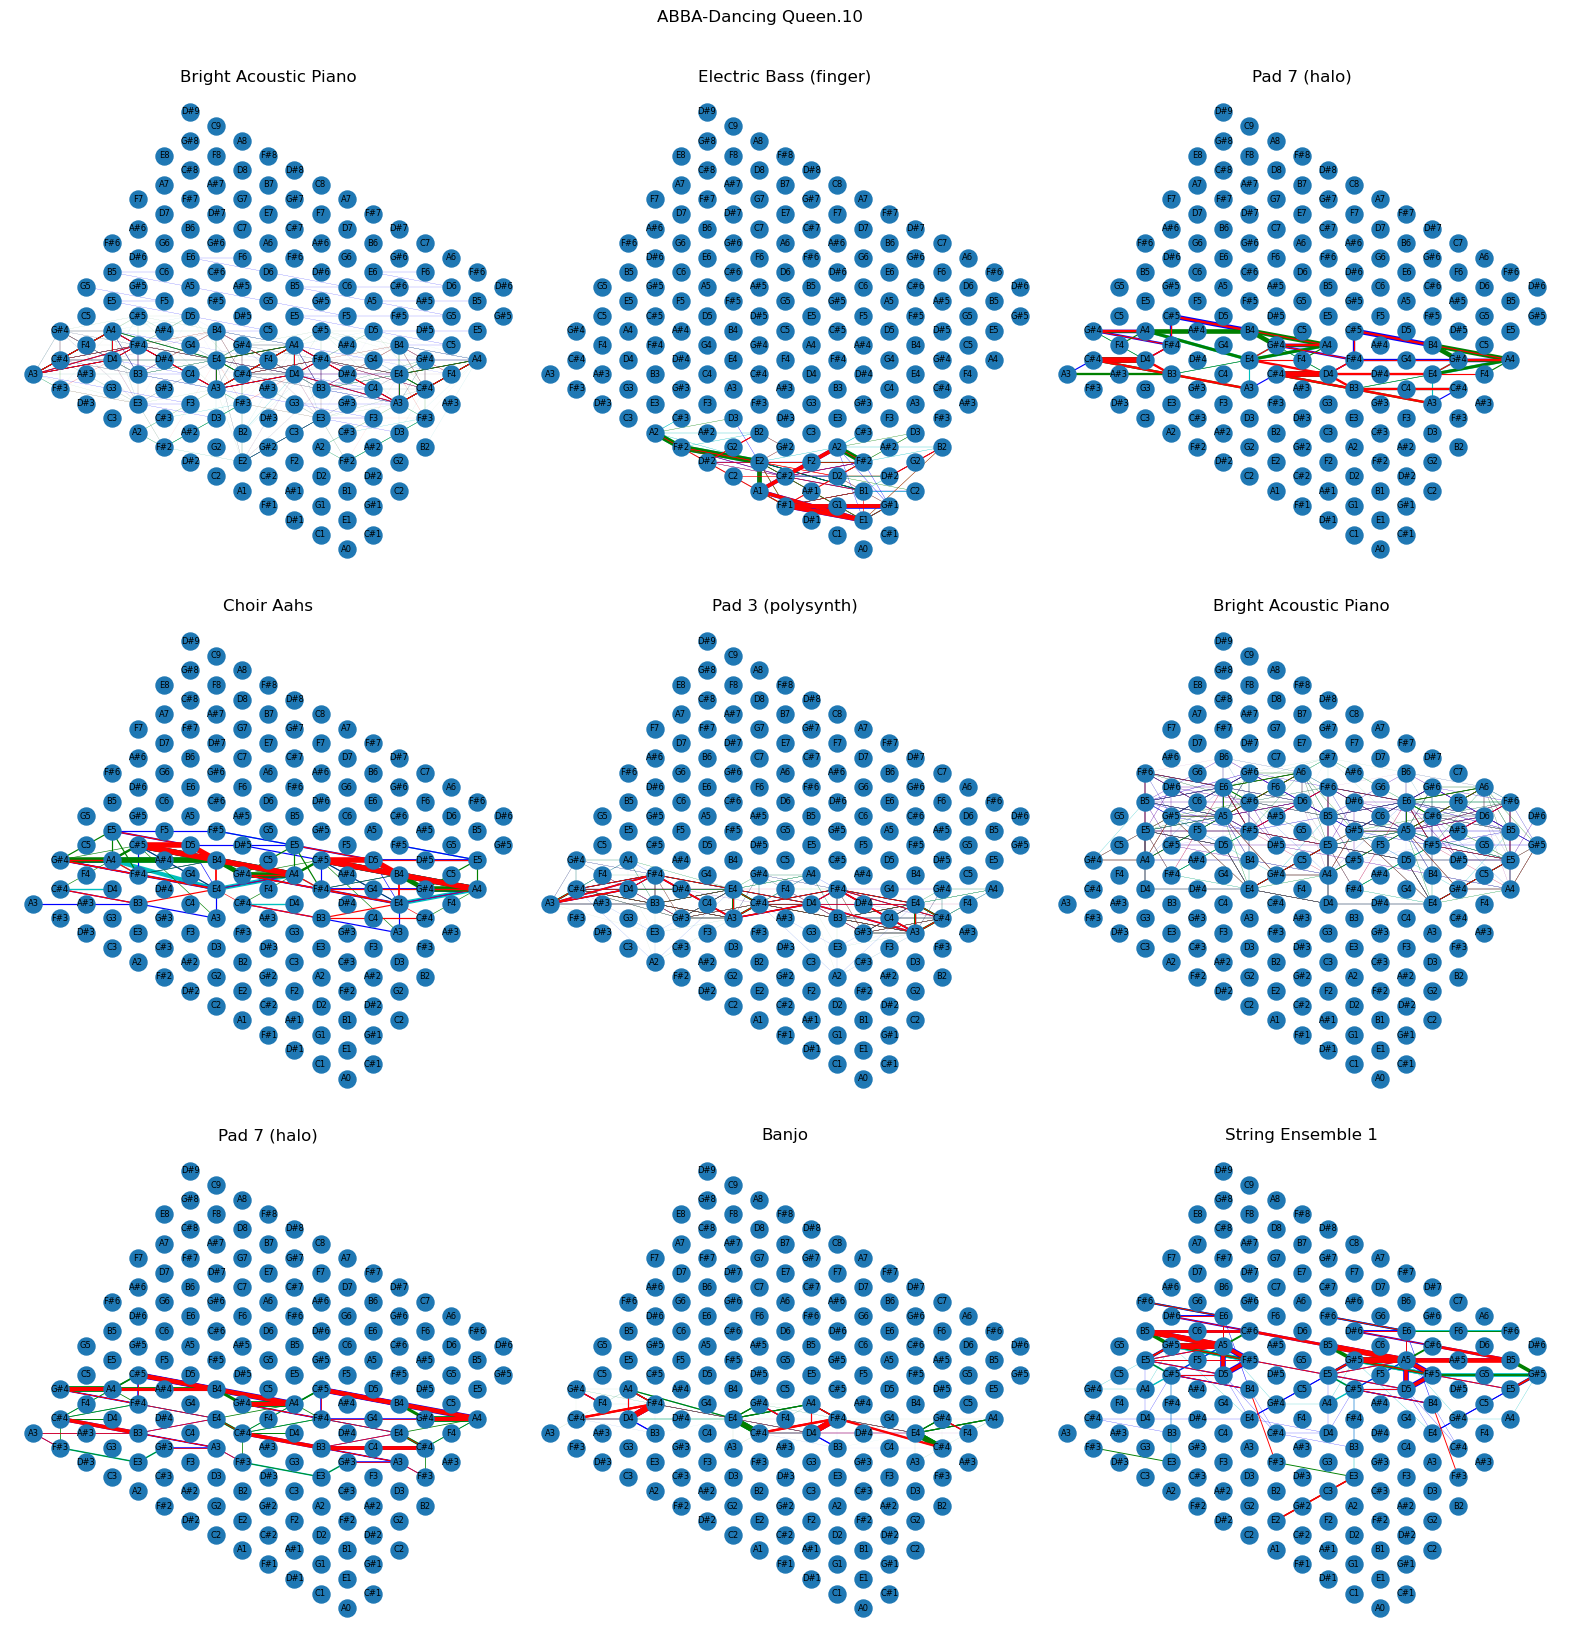

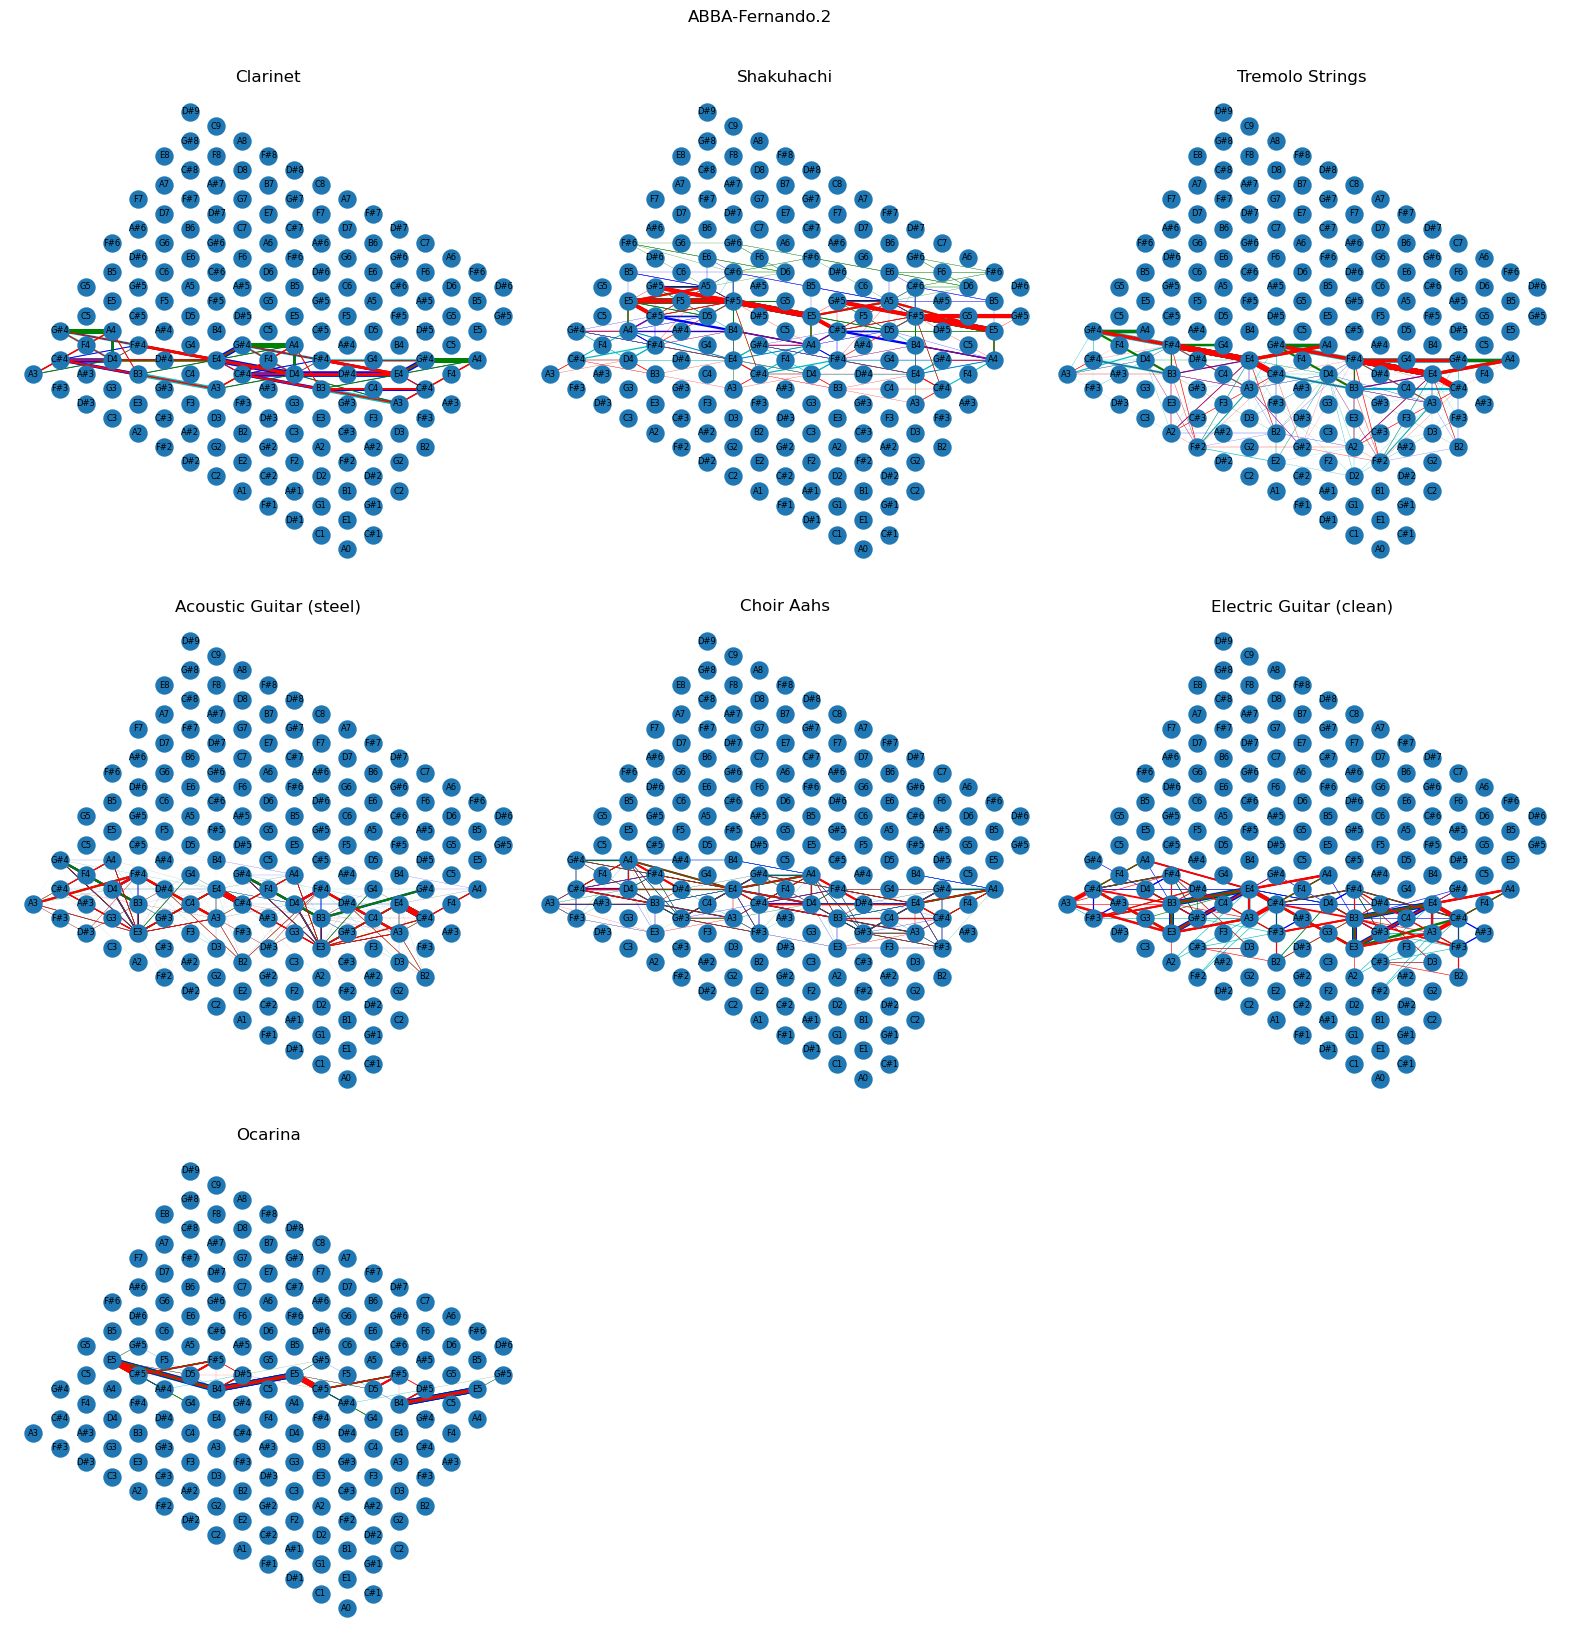

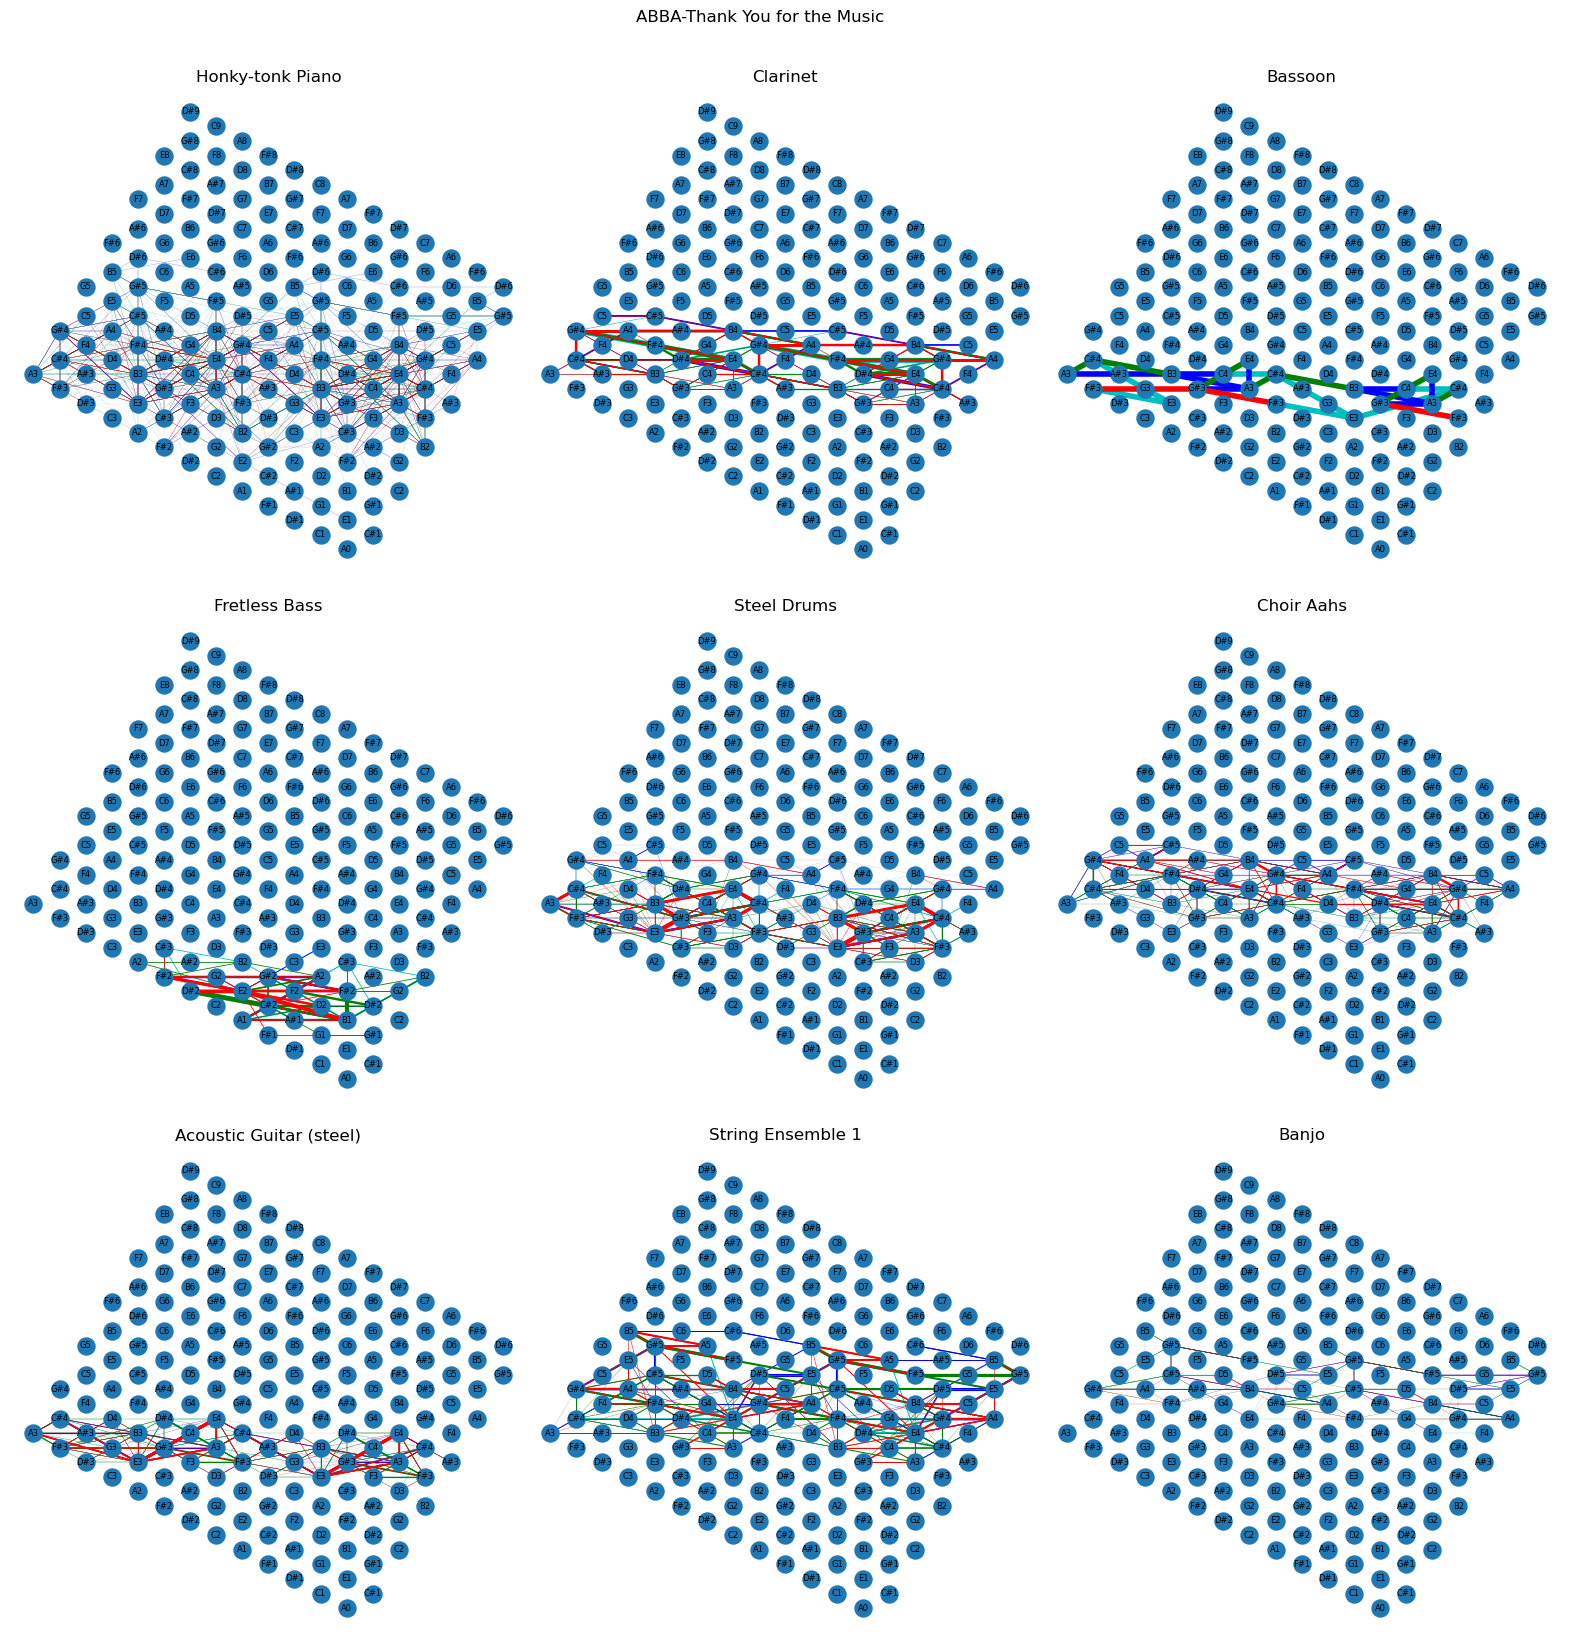

In [8]:
dq.draw(save_file=False, show_image=True)
AnalyzedSong("ABBA-Dancing Queen.10.pickle").draw(save_file=False, show_image=True)
AnalyzedSong("ABBA-Fernando.2.pickle").draw(save_file=False, show_image=True)
AnalyzedSong("ABBA-Thank You for the Music.pickle").draw(save_file=False, show_image=True)

#### Dissimilar Songs (To Dancing Queen 1)

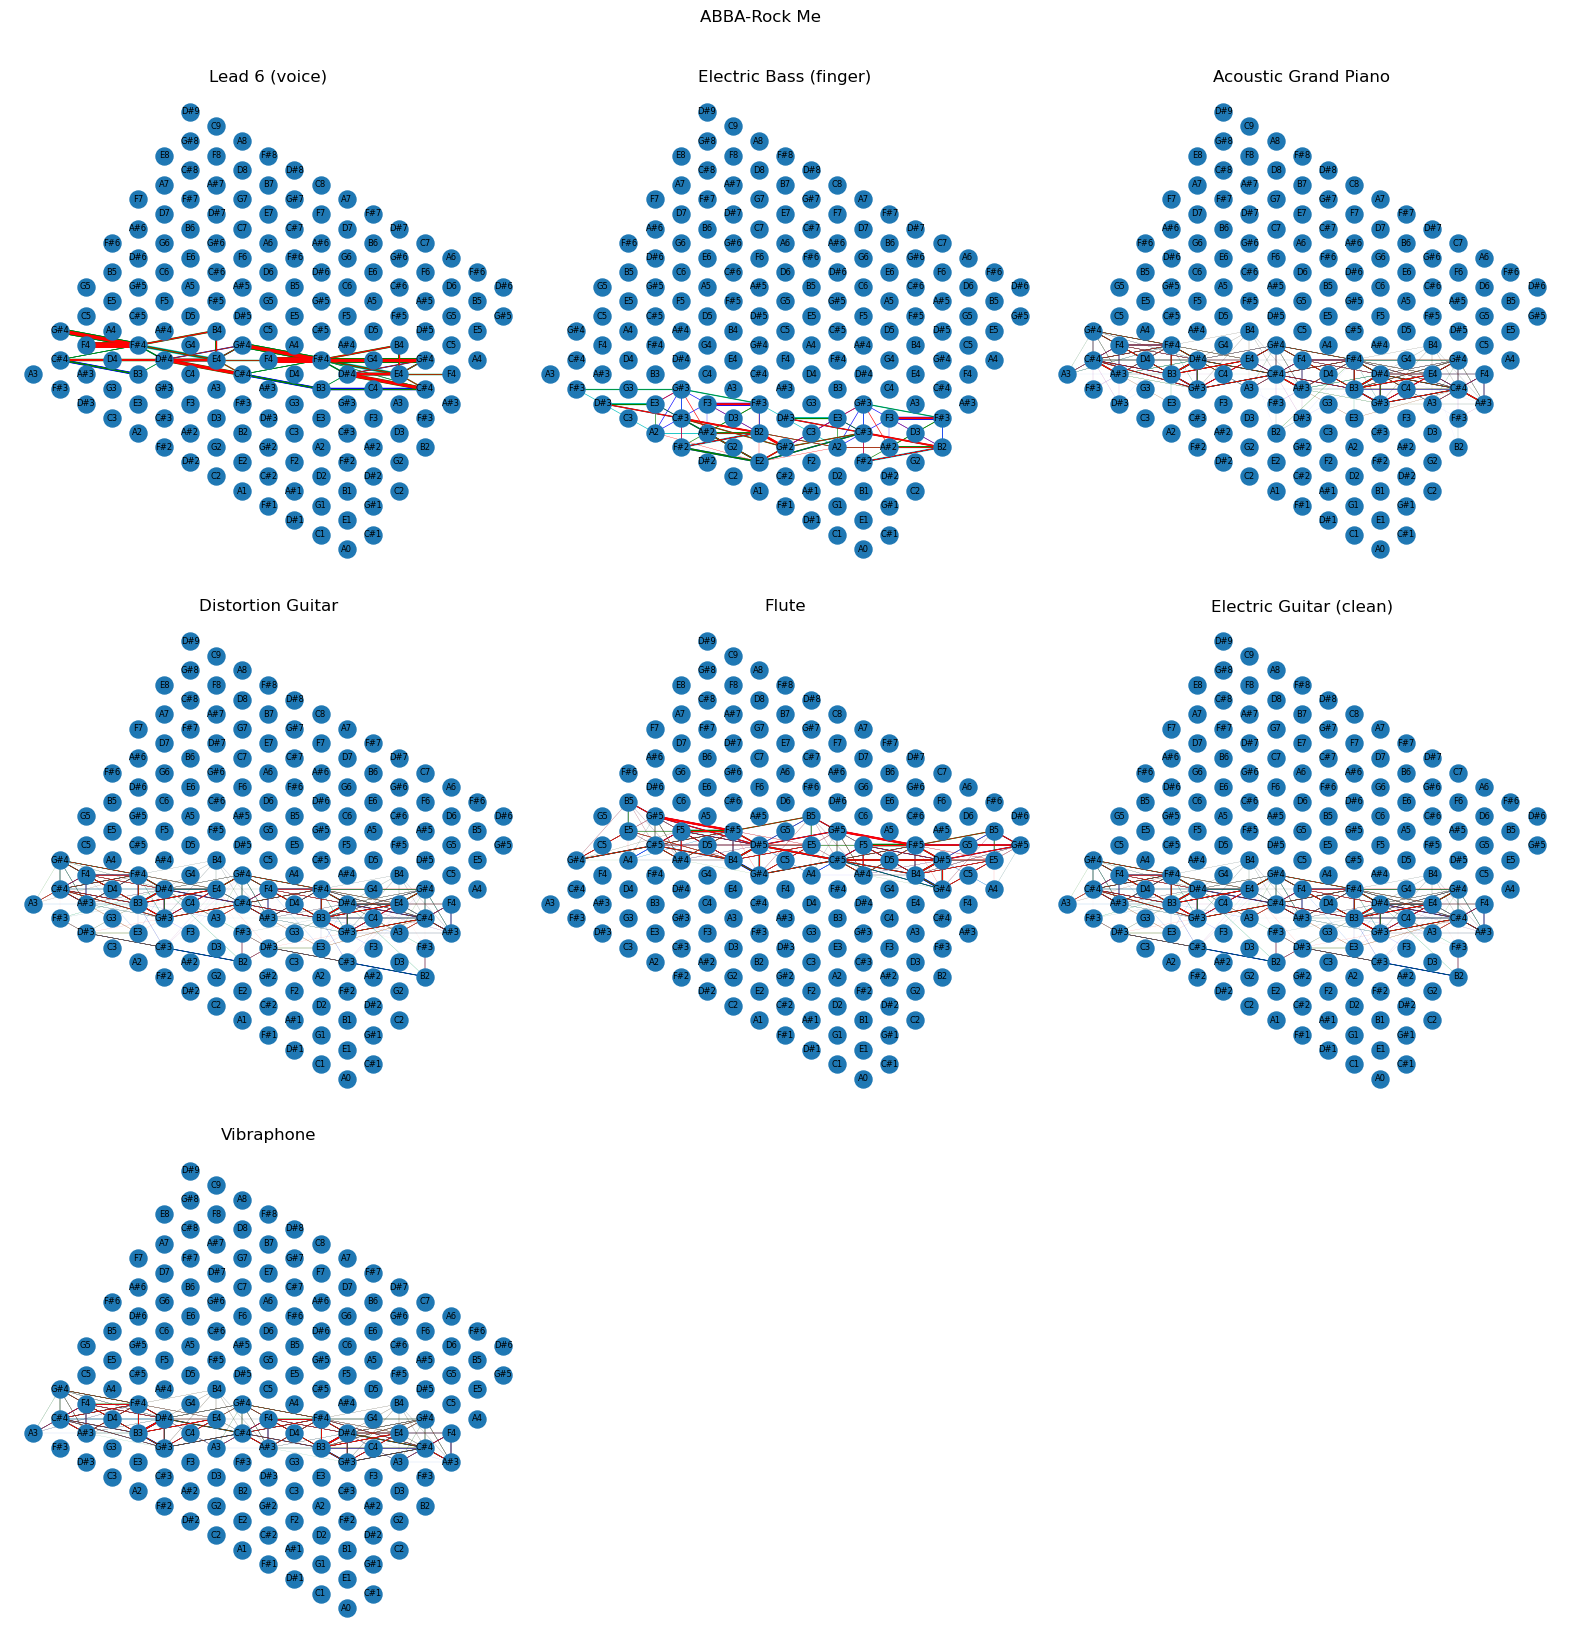

In [10]:
AnalyzedSong("ABBA-Rock Me").draw(save_file=False, show_image=True)

## Similarity Matrix

 37%|███▋      | 63/171 [00:33<00:41,  2.60it/s]

I Have a Dream.mid: list index out of range


 39%|███▊      | 66/171 [00:37<01:00,  1.73it/s]

I've Been Waiting For You.mid: data byte must be in range 0..127


 66%|██████▌   | 113/171 [01:05<00:40,  1.44it/s]

One Of Us.mid: data byte must be in range 0..127


  0%|          | 0/16 [00:00<?, ?it/s]/Users/dziper/opt/anaconda3/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Back In Black.mid: list index out of range


 50%|█████     | 8/16 [00:08<00:09,  1.13s/it]

TNT.mid: list index out of range


  0%|          | 0/157 [00:00<?, ?it/s]

(Anesthesia)-Pulling Teeth.mid: 


 20%|█▉        | 31/157 [00:24<01:23,  1.50it/s]

Dont Tread on Me.mid: list index out of range


 96%|█████████▌| 150/157 [02:08<00:04,  1.41it/s]

Wherever I May Roam.mid: list index out of range


100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


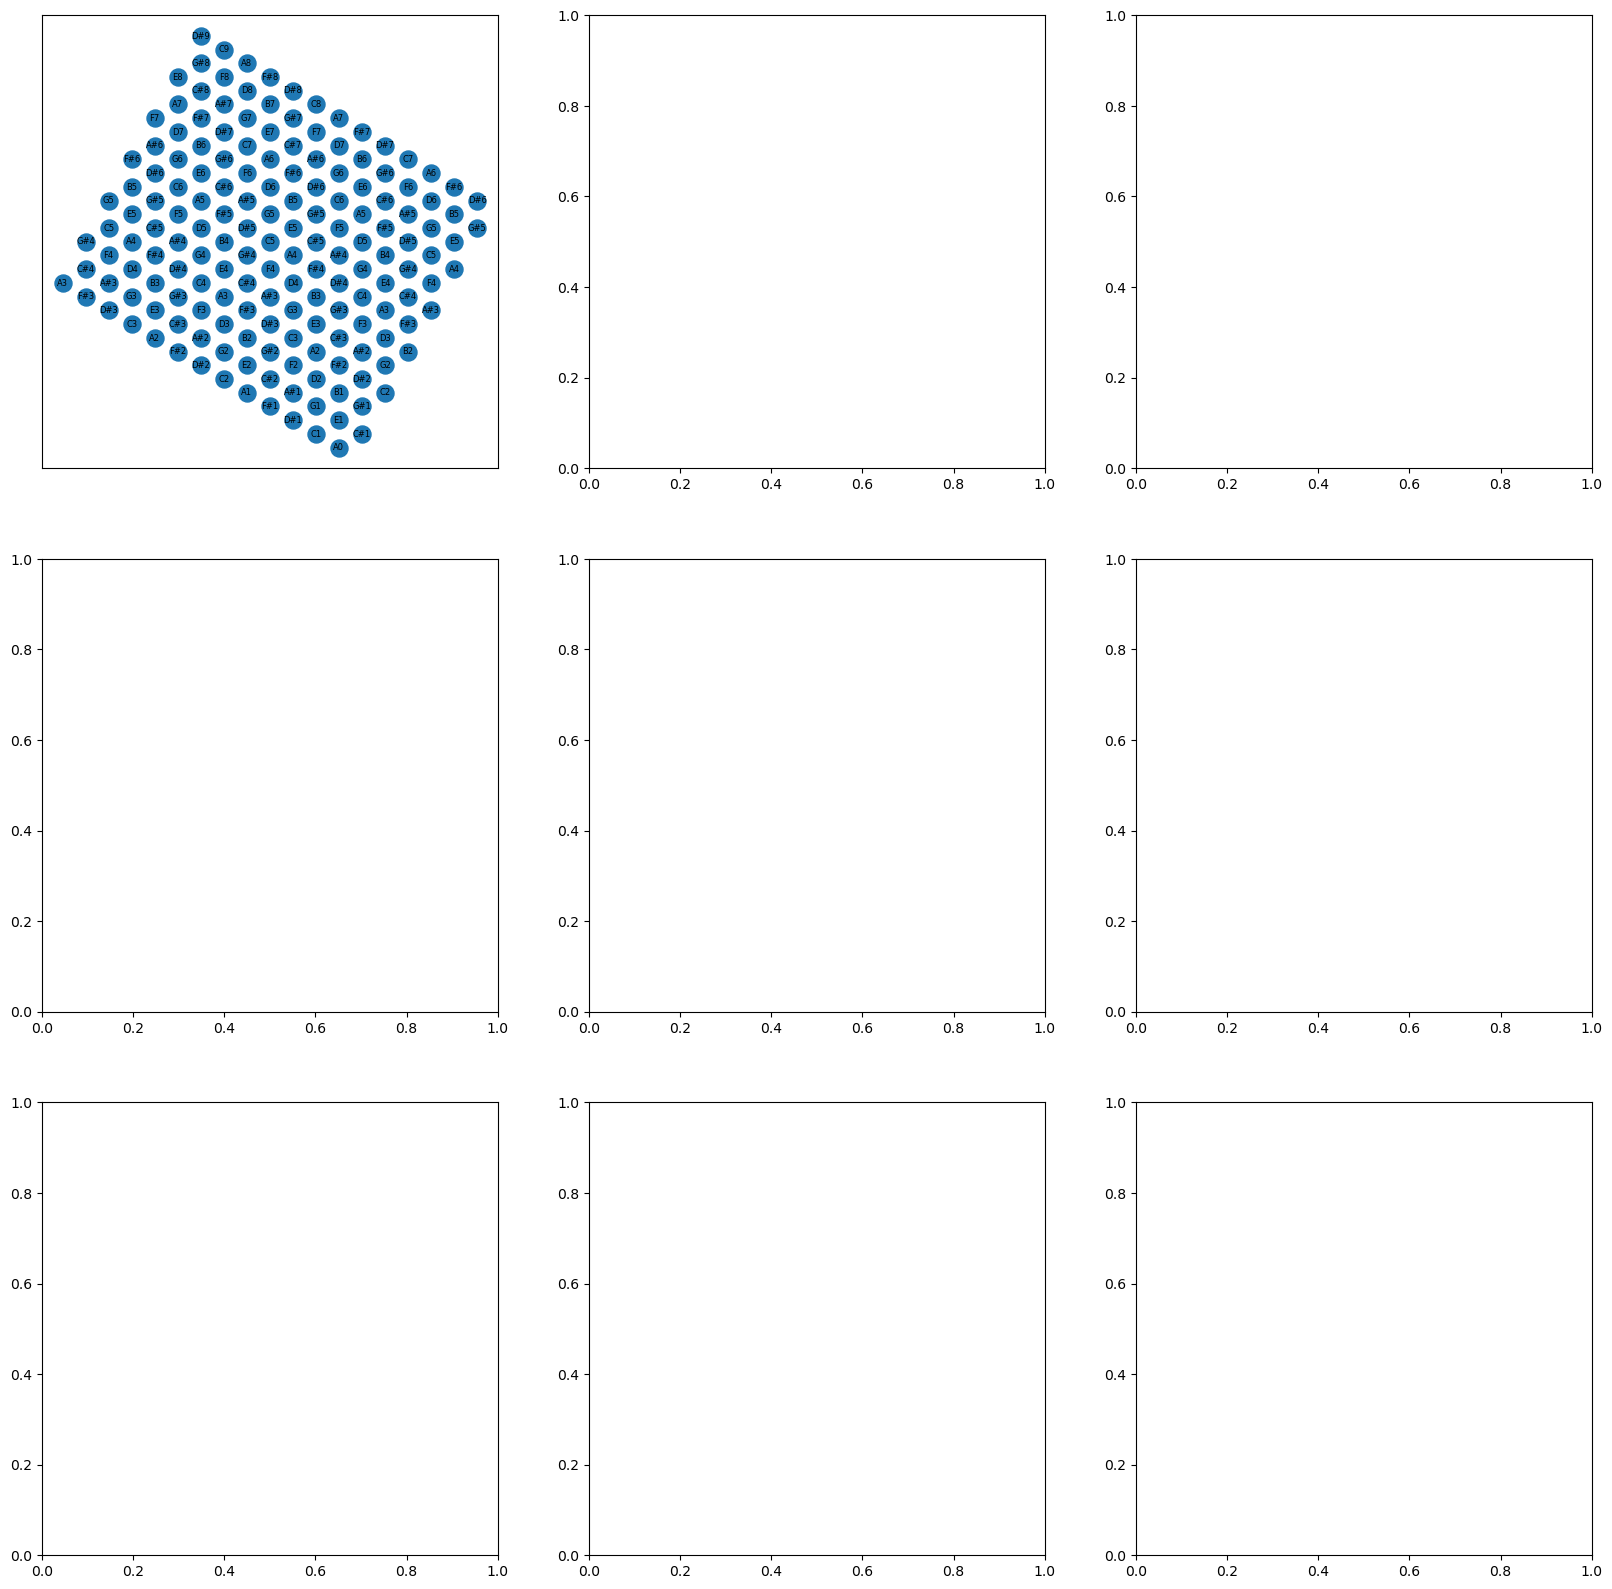

In [19]:
import song
song.analyze_artist("ABBA")
song.analyze_artist("AC DC")
song.analyze_artist("Metallica")

In [20]:
import numpy as np

def compute_similarity_matrix(song_ids, similarity_function):
    n = len(song_ids)
    similarity_matrix = np.zeros((n, n))
    for i in tqdm(range(n)):
        currSong = AnalyzedSong(song_ids[i])
        for j in range(i, n):
            similarity_matrix[i, j] = similarity_function(currSong, AnalyzedSong(song_ids[j]))
            similarity_matrix[j, i] = similarity_matrix[i, j]  # Symmetric matrix
    return similarity_matrix



In [21]:
import os
import utils
from tqdm import tqdm

songs = os.listdir(os.path.join(utils.OUTPUT_ROOT, "songPickles"))
songs = list(filter(lambda s: any(char.isdigit for char in s), songs))
print(len(songs), songs)

similarity_matrix = compute_similarity_matrix(songs, simple_compare)

# 
# plt.figure(figsize=(10, 8))
# sns.heatmap(similarity_matrix, cmap='viridis')
# plt.title("Similarity Matrix Heatmap")
# plt.xlabel("Object Index")
# plt.ylabel("Object Index")
# plt.show()

  0%|          | 0/122 [00:00<?, ?it/s]

122 ['ABBA-Medley.pickle', 'Metallica-Fade to Black.pickle', 'Metallica-Carpe Diem Baby.pickle', 'Metallica-The Memory Remains.pickle', 'Metallica-Turn the Page.pickle', 'Metallica-Wasting My Hate.pickle', 'ABBA-Thank You for the Music.pickle', 'Metallica-Fight Fire With Fire.pickle', 'Metallica-Seek & Destroy.pickle', 'ABBA-Name of the Game.pickle', 'Metallica-Holier Than Thou.pickle', 'ABBA-Two for the Price of One.pickle', 'ABBA-The Visitors.pickle', 'ABBA-Chiquitita.pickle', 'Metallica-Ride the Lightning.pickle', 'Metallica-My Friend of Misery.pickle', 'ABBA-Money, Money, Money.pickle', 'ABBA-The Winner Takes It All.pickle', 'ABBA-Lay All Your Love on Me.pickle', 'Metallica-Metal Militia.pickle', 'AC DC-Dirty Deeds Done Dirt Cheap.pickle', 'Metallica-One.pickle', 'Metallica-The Four Horsemen.pickle', 'Metallica-Through the Never.pickle', 'Metallica-To Live Is to Die.pickle', 'ABBA-Andante, Andante.pickle', 'Metallica-Harvester of Sorrow.pickle', 'AC DC-R.I.P. (Rock in Peace).pickle

100%|██████████| 122/122 [00:53<00:00,  2.28it/s]


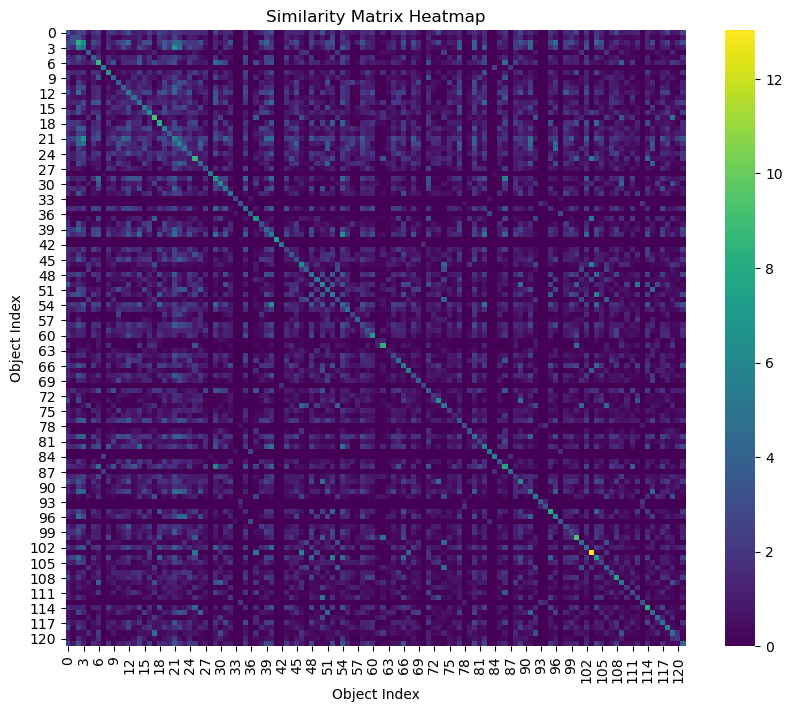

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title("Similarity Matrix Heatmap")
plt.xlabel("Object Index")
plt.ylabel("Object Index")
plt.show()


In [25]:
pairs = []
n = similarity_matrix.shape[0]
for i in range(n):
    for j in range(i + 1, n):  # Exclude the diagonal and avoid duplicate pairs
        pairs.append(((i, j), similarity_matrix[i, j]))

# Step 3: Sort the Pairs by Similarity Scores
pairs.sort(key=lambda x: x[1], reverse=True)

# Step 4: Print the Top 20 Pairs
top_20_pairs = pairs[:20]
print("Top 20 pairs with the highest similarity scores:")
for pair, score in top_20_pairs:
    print(f"{songs[pair[0]][:-7]} / {songs[pair[1]][:-7]}, Similarity: {score}")


Top 20 pairs with the highest similarity scores:
Metallica-The Memory Remains / Metallica-One, Similarity: 6.834161425199067
Metallica-Outlaw Torn / Metallica-The Struggle Within, Similarity: 6.5137811944094315
Metallica-Carpe Diem Baby / Metallica-The Memory Remains, Similarity: 6.180654435520675
ABBA-Fernando / ABBA-Dancing Queen, Similarity: 5.868188827988012
Metallica-Poor Twisted Me / Metallica-King Nothing, Similarity: 5.787510140701164
ABBA-Super Trooper / ABBA-Super Trouper, Similarity: 5.773027980779112
ABBA-Andante, Andante / Metallica-King Nothing, Similarity: 5.291686203248236
Metallica-Ronnie / Metallica-King Nothing, Similarity: 5.2071075115468135
Metallica-Outlaw Torn / Metallica-No Remorse, Similarity: 5.193690315379016
ABBA-Summer Night City / Metallica-Last Caress, Similarity: 5.0756215888865945
Metallica-The Struggle Within / Metallica-No Remorse, Similarity: 5.070891049457462
ABBA-The Winner Takes It All / ABBA-That's Me, Similarity: 4.9785525347242805
Metallica-One

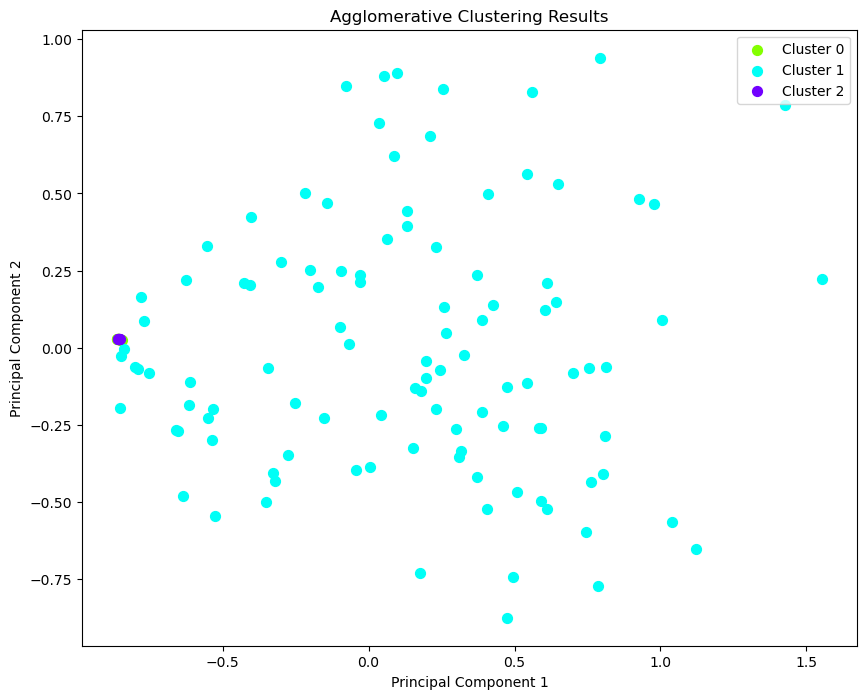

In [29]:
from sklearn.cluster import AgglomerativeClustering
distance_matrix = (10 - similarity_matrix)/10
agg_clustering = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='average')
labels = agg_clustering.fit_predict(distance_matrix)

palette = sns.color_palette("hsv", np.unique(labels).max() + 1)

# Visualize clustering results on a scatter plot of the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(distance_matrix)

plt.figure(figsize=(10, 8))
for cluster in np.unique(labels):
    cluster_points = reduced_data[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, color=palette[cluster], label=f'Cluster {cluster}')

plt.title('Agglomerative Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
# 
# # Optionally, plot the dendrogram for hierarchical clustering
# linkage_matrix = linkage(squareform(distance_matrix), method='average')
# plt.figure(figsize=(15, 8))
# dendrogram(linkage_matrix)
# plt.title('Dendrogram for Agglomerative Clustering')
# plt.xlabel('Sample Index')
# plt.ylabel('Distance')
# plt.show()
# 